# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef as phi_coef
import json
from torch import save, load

In [3]:
import phik

#from phik import resources
#from phik.binning import bin_data
from phik.report import plot_correlation_matrix

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [4]:
seed = 60412887 #randint(0, 4294967295)
print(seed)

60412887


In [5]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure', 
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
0  70.0  1.0         4.0           130.0        322.0          0.0   
1  67.0  0.0         3.0           115.0        564.0          0.0   
2  57.0  1.0         2.0           124.0        261.0          0.0   
3  64.0  1.0         4.0           128.0        263.0          0.0   
4  74.0  0.0         2.0           120.0        269.0          0.0   

   eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
0             2.0           109.0          0.0      2.4         2.0   
1             2.0           160.0          0.0      1.6         2.0   
2             0.0           141.0          0.0      0.3         1.0   
3             0.0           105.0          1.0      0.2         2.0   
4             2.0           121.0          1.0      0.2         1.0   

   major_vessels  thal  target  
0            3.0   3.0       1  
1            0.0   7.0       0  
2            0.0   7.0       1  
3            1.0   7.0       0  
4            1.0   3.0       0

<Axes: >

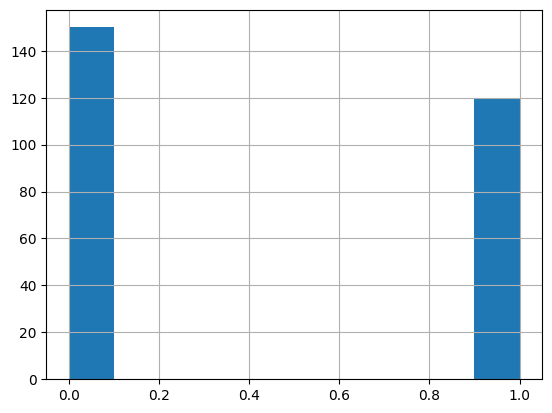

In [6]:
df['target'].hist()

<Axes: >

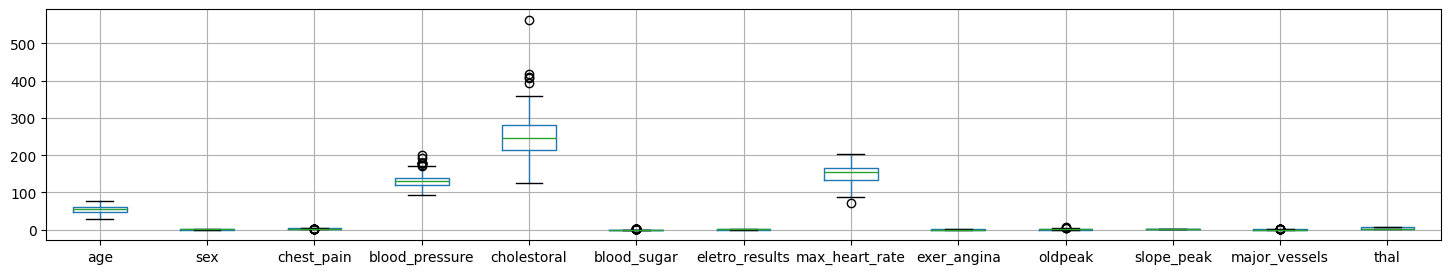

In [7]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

<Axes: >

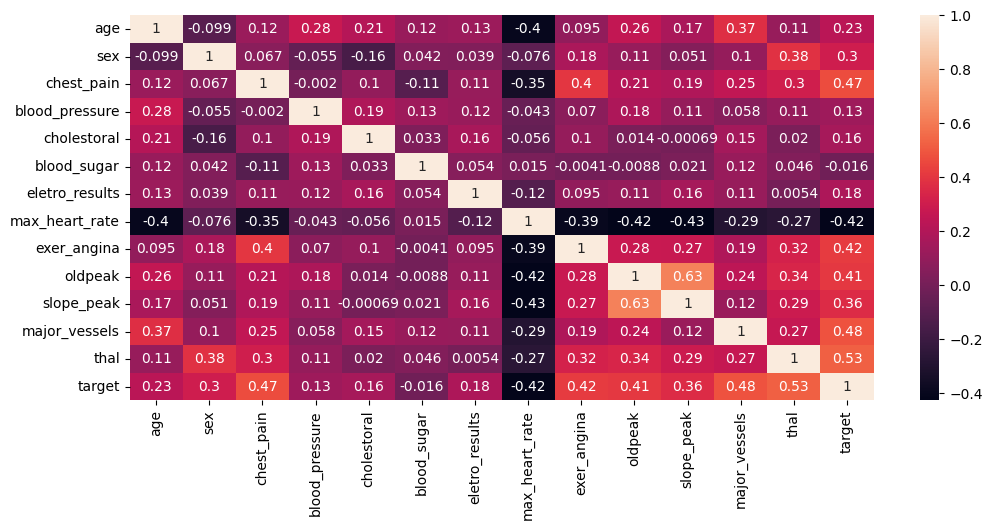

In [8]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('spearman'), annot=True)

In [9]:
df.corr('spearman').dtypes

age               float64
sex               float64
chest_pain        float64
blood_pressure    float64
cholestoral       float64
blood_sugar       float64
eletro_results    float64
max_heart_rate    float64
exer_angina       float64
oldpeak           float64
slope_peak        float64
major_vessels     float64
thal              float64
target            float64
dtype: object

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [10]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [11]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

In [12]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [13]:
NUM_TRIALS = 25
performs = {}
models_error = pd.DataFrame()
models = []

In [14]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    #try:
    #    pred_proba = model.predict_proba(train_set[0])[:, 1]
    #    pred_proba = [1-max(prob) for prob in pred_proba]
    #except AttributeError:
    #    pred_proba = model.decision_function(train_set[0])
    #    check = False
    #else:
    #    check = True

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])

    #if(check):
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]
    #else:
    #    pred_proba = model.decision_function(test_set[0])

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}

### Decision Tree

In [15]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 60}


In [16]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.7979
Recall:           0.8250
Precision:        0.7333
F1:               0.7765
AUROC:            0.8014
AUPR:             0.6795
1-maxProb média:  0.2021
1-maxProb dp:     0.0618

[Testing]

Accuracy:         0.7474
Recall:           0.7045
Precision:        0.7381
F1:               0.7209
AUROC:            0.7444
AUPR:             0.6569
1-maxProb média:  0.1976
1-maxProb dp:     0.0615


In [17]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0  0.733333
1  0.142857
2  0.857143
3  0.266667
4  0.266667

In [18]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [19]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.001, 'loss': 'modified_huber', 'penalty': 'l2'}


In [20]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.8511
Recall:           0.8250
Precision:        0.8250
F1:               0.8250
AUROC:            0.8662
AUPR:             0.7826
1-maxProb média:  0.0067
1-maxProb dp:     0.0456

[Testing]

Accuracy:         0.8000
Recall:           0.6818
Precision:        0.8571
F1:               0.7595
AUROC:            0.7986
AUPR:             0.7490
1-maxProb média:  0.0031
1-maxProb dp:     0.0301


### Logistic Regression

In [21]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [22]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.8830
Recall:           0.8750
Precision:        0.8537
F1:               0.8642
AUROC:            0.9509
AUPR:             0.9388
1-maxProb média:  0.3741
1-maxProb dp:     0.0711

[Testing]

Accuracy:         0.8211
Recall:           0.7500
Precision:        0.8462
F1:               0.7952
AUROC:            0.9184
AUPR:             0.9085
1-maxProb média:  0.3609
1-maxProb dp:     0.0711


### K-Nearest Neighbors

(KNN)

In [23]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


In [24]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

[Training]

Accuracy:         0.9149
Recall:           0.8500
Precision:        0.9444
F1:               0.8947
AUROC:            0.9697
AUPR:             0.9538
1-maxProb média:  0.1213
1-maxProb dp:     0.1436

[Testing]

Accuracy:         0.8000
Recall:           0.6591
Precision:        0.8788
F1:               0.7532
AUROC:            0.8968
AUPR:             0.8617
1-maxProb média:  0.1411
1-maxProb dp:     0.1559


### Support Vector Machine - Linear
(SVM)

In [25]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 0.1}


In [26]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.9149
Recall:           0.8750
Precision:        0.9211
F1:               0.8974
AUROC:            0.9630
AUPR:             0.9444
1-maxProb média:  0.1702
1-maxProb dp:     0.1280

[Testing]

Accuracy:         0.8421
Recall:           0.7727
Precision:        0.8718
F1:               0.8193
AUROC:            0.9234
AUPR:             0.9108
1-maxProb média:  0.1469
1-maxProb dp:     0.1313


### Support Vector Machine - Polynomial
(SVM)

In [27]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 1, 'degree': 3, 'gamma': 'scale'}


In [28]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9574
Recall:           0.9000
Precision:        1.0000
F1:               0.9474
AUROC:            0.9986
AUPR:             0.9981
1-maxProb média:  0.0932
1-maxProb dp:     0.1111

[Testing]

Accuracy:         0.8526
Recall:           0.7500
Precision:        0.9167
F1:               0.8250
AUROC:            0.8801
AUPR:             0.8544
1-maxProb média:  0.1042
1-maxProb dp:     0.1226


### Support Vector Machine - RBF
(SVM)

In [29]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [30]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.9468
Recall:           0.9000
Precision:        0.9730
F1:               0.9351
AUROC:            0.9931
AUPR:             0.9905
1-maxProb média:  0.0934
1-maxProb dp:     0.0960

[Testing]

Accuracy:         0.8105
Recall:           0.6364
Precision:        0.9333
F1:               0.7568
AUROC:            0.9135
AUPR:             0.8953
1-maxProb média:  0.1644
1-maxProb dp:     0.1574


### Multi-Layer Perceptron
(MLP)

In [31]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}


In [32]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0175
1-maxProb dp:     0.0313

[Testing]

Accuracy:         0.8316
Recall:           0.7727
Precision:        0.8500
F1:               0.8095
AUROC:            0.8859
AUPR:             0.8760
1-maxProb média:  0.0349
1-maxProb dp:     0.0774


### Kolmogorov-Arnold Network
(KAN)

In [33]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [34]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/heart.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/heart.pkl')
    save(kanet.state_dict(), 'kan_params/heart.pt')
else:
    with open('kan_params/heart.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/heart.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

width: [[13, 0], [3, 0], [2, 0]],
grid: 8,
lr: 0.0001,
lamb: 0.005


In [35]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0104
1-maxProb dp:     0.0272

[Testing]

Accuracy:         0.7789
Recall:           0.6136
Precision:        0.8710
F1:               0.7200
AUROC:            0.8409
AUPR:             0.8584
1-maxProb média:  0.0353
1-maxProb dp:     0.0849


### Random Forest

In [36]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


In [37]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.1112
1-maxProb dp:     0.0923

[Testing]

Accuracy:         0.8316
Recall:           0.7273
Precision:        0.8889
F1:               0.8000
AUROC:            0.9191
AUPR:             0.8999
1-maxProb média:  0.2053
1-maxProb dp:     0.1423


### Gradient Boosting

In [38]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 40, 'n_estimators': 150}


In [39]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0084
1-maxProb dp:     0.0092

[Testing]

Accuracy:         0.8316
Recall:           0.7727
Precision:        0.8500
F1:               0.8095
AUROC:            0.8984
AUPR:             0.8790
1-maxProb média:  0.0522
1-maxProb dp:     0.0982


### AdaBoost

In [40]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.1, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [41]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.9574
Recall:           0.9500
Precision:        0.9500
F1:               0.9500
AUROC:            0.9981
AUPR:             0.9976
1-maxProb média:  0.4255
1-maxProb dp:     0.0508

[Testing]

Accuracy:         0.8105
Recall:           0.6818
Precision:        0.8824
F1:               0.7692
AUROC:            0.8857
AUPR:             0.8305
1-maxProb média:  0.4237
1-maxProb dp:     0.0490


### XGBoost

In [42]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 150}


In [43]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0784
1-maxProb dp:     0.0837

[Testing]

Accuracy:         0.8211
Recall:           0.7500
Precision:        0.8462
F1:               0.7952
AUROC:            0.9033
AUPR:             0.8933
1-maxProb média:  0.0948
1-maxProb dp:     0.1139


## Análise de Correlações

In [44]:
groups = {}
model_names = list(performs.keys())

In [45]:
pred_corrls = pd.DataFrame(columns=models_error.columns, index=models_error.columns, dtype=float)

ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    #pred_hits[model_names[i]] = np.argmax(y_pred, axis=1) != yb_test
    # np.arange vai retornar os índices das duplas de probabilidades.
    # yb_test vai epecificar o índice (classe) da probabilidade da classe correta
    # dentro de cada dupla de probabilidades.
    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]

#for m in models_error.columns:
#    for n in models_error.columns:
#        pred_corrls.at[m,n] = phi_coef(models_error[m], models_error[n])


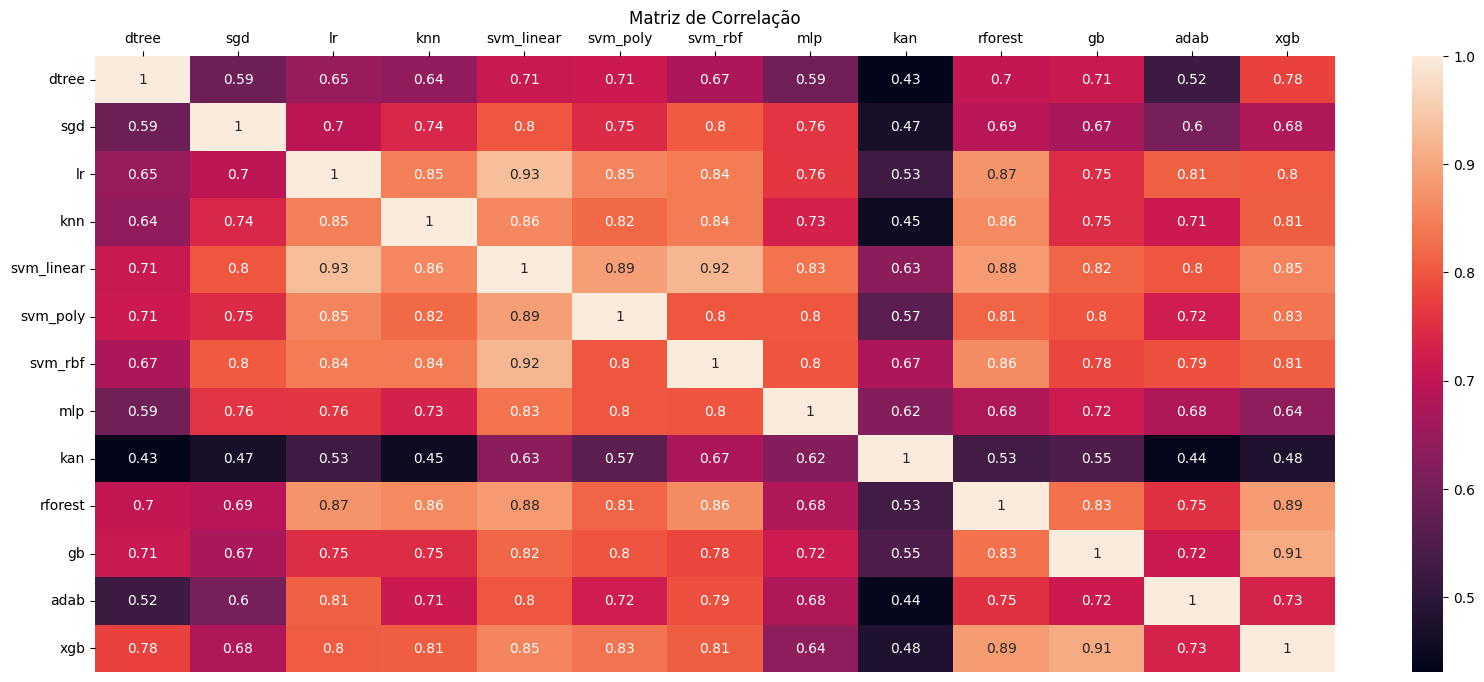

            corr
count  78.000000
mean    0.730929
std     0.121712
min     0.430756
25%     0.673653
50%     0.747511
75%     0.816250
max     0.931612


<Axes: >

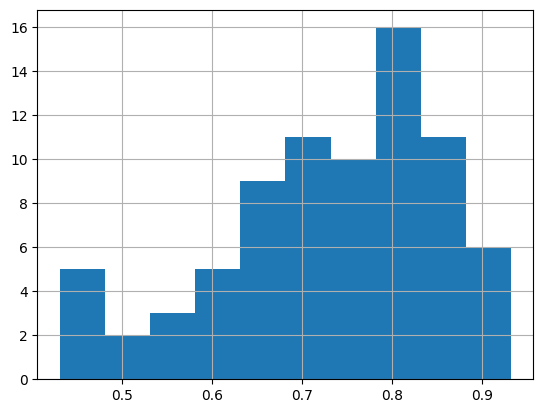

In [65]:
pred_corrls = models_error.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('Matriz de Correlação')
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

corrls_values = pred_corrls.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
#df = df.rename(columns={'index': 'assessor_type'})
corrls_values = corrls_values.rename(columns={'index': 'model1'})
corrls_values = corrls_values[corrls_values['model1']!=corrls_values['model2']].reset_index(drop=True)
# ordenando strings por linha
corrls_values.loc[:,['model1','model2']] = pd.DataFrame(np.sort(corrls_values.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2']) 
corrls_values = corrls_values.drop_duplicates().reset_index(drop=True)

print(corrls_values[['corr']].describe())

corrls_values['corr'].hist()

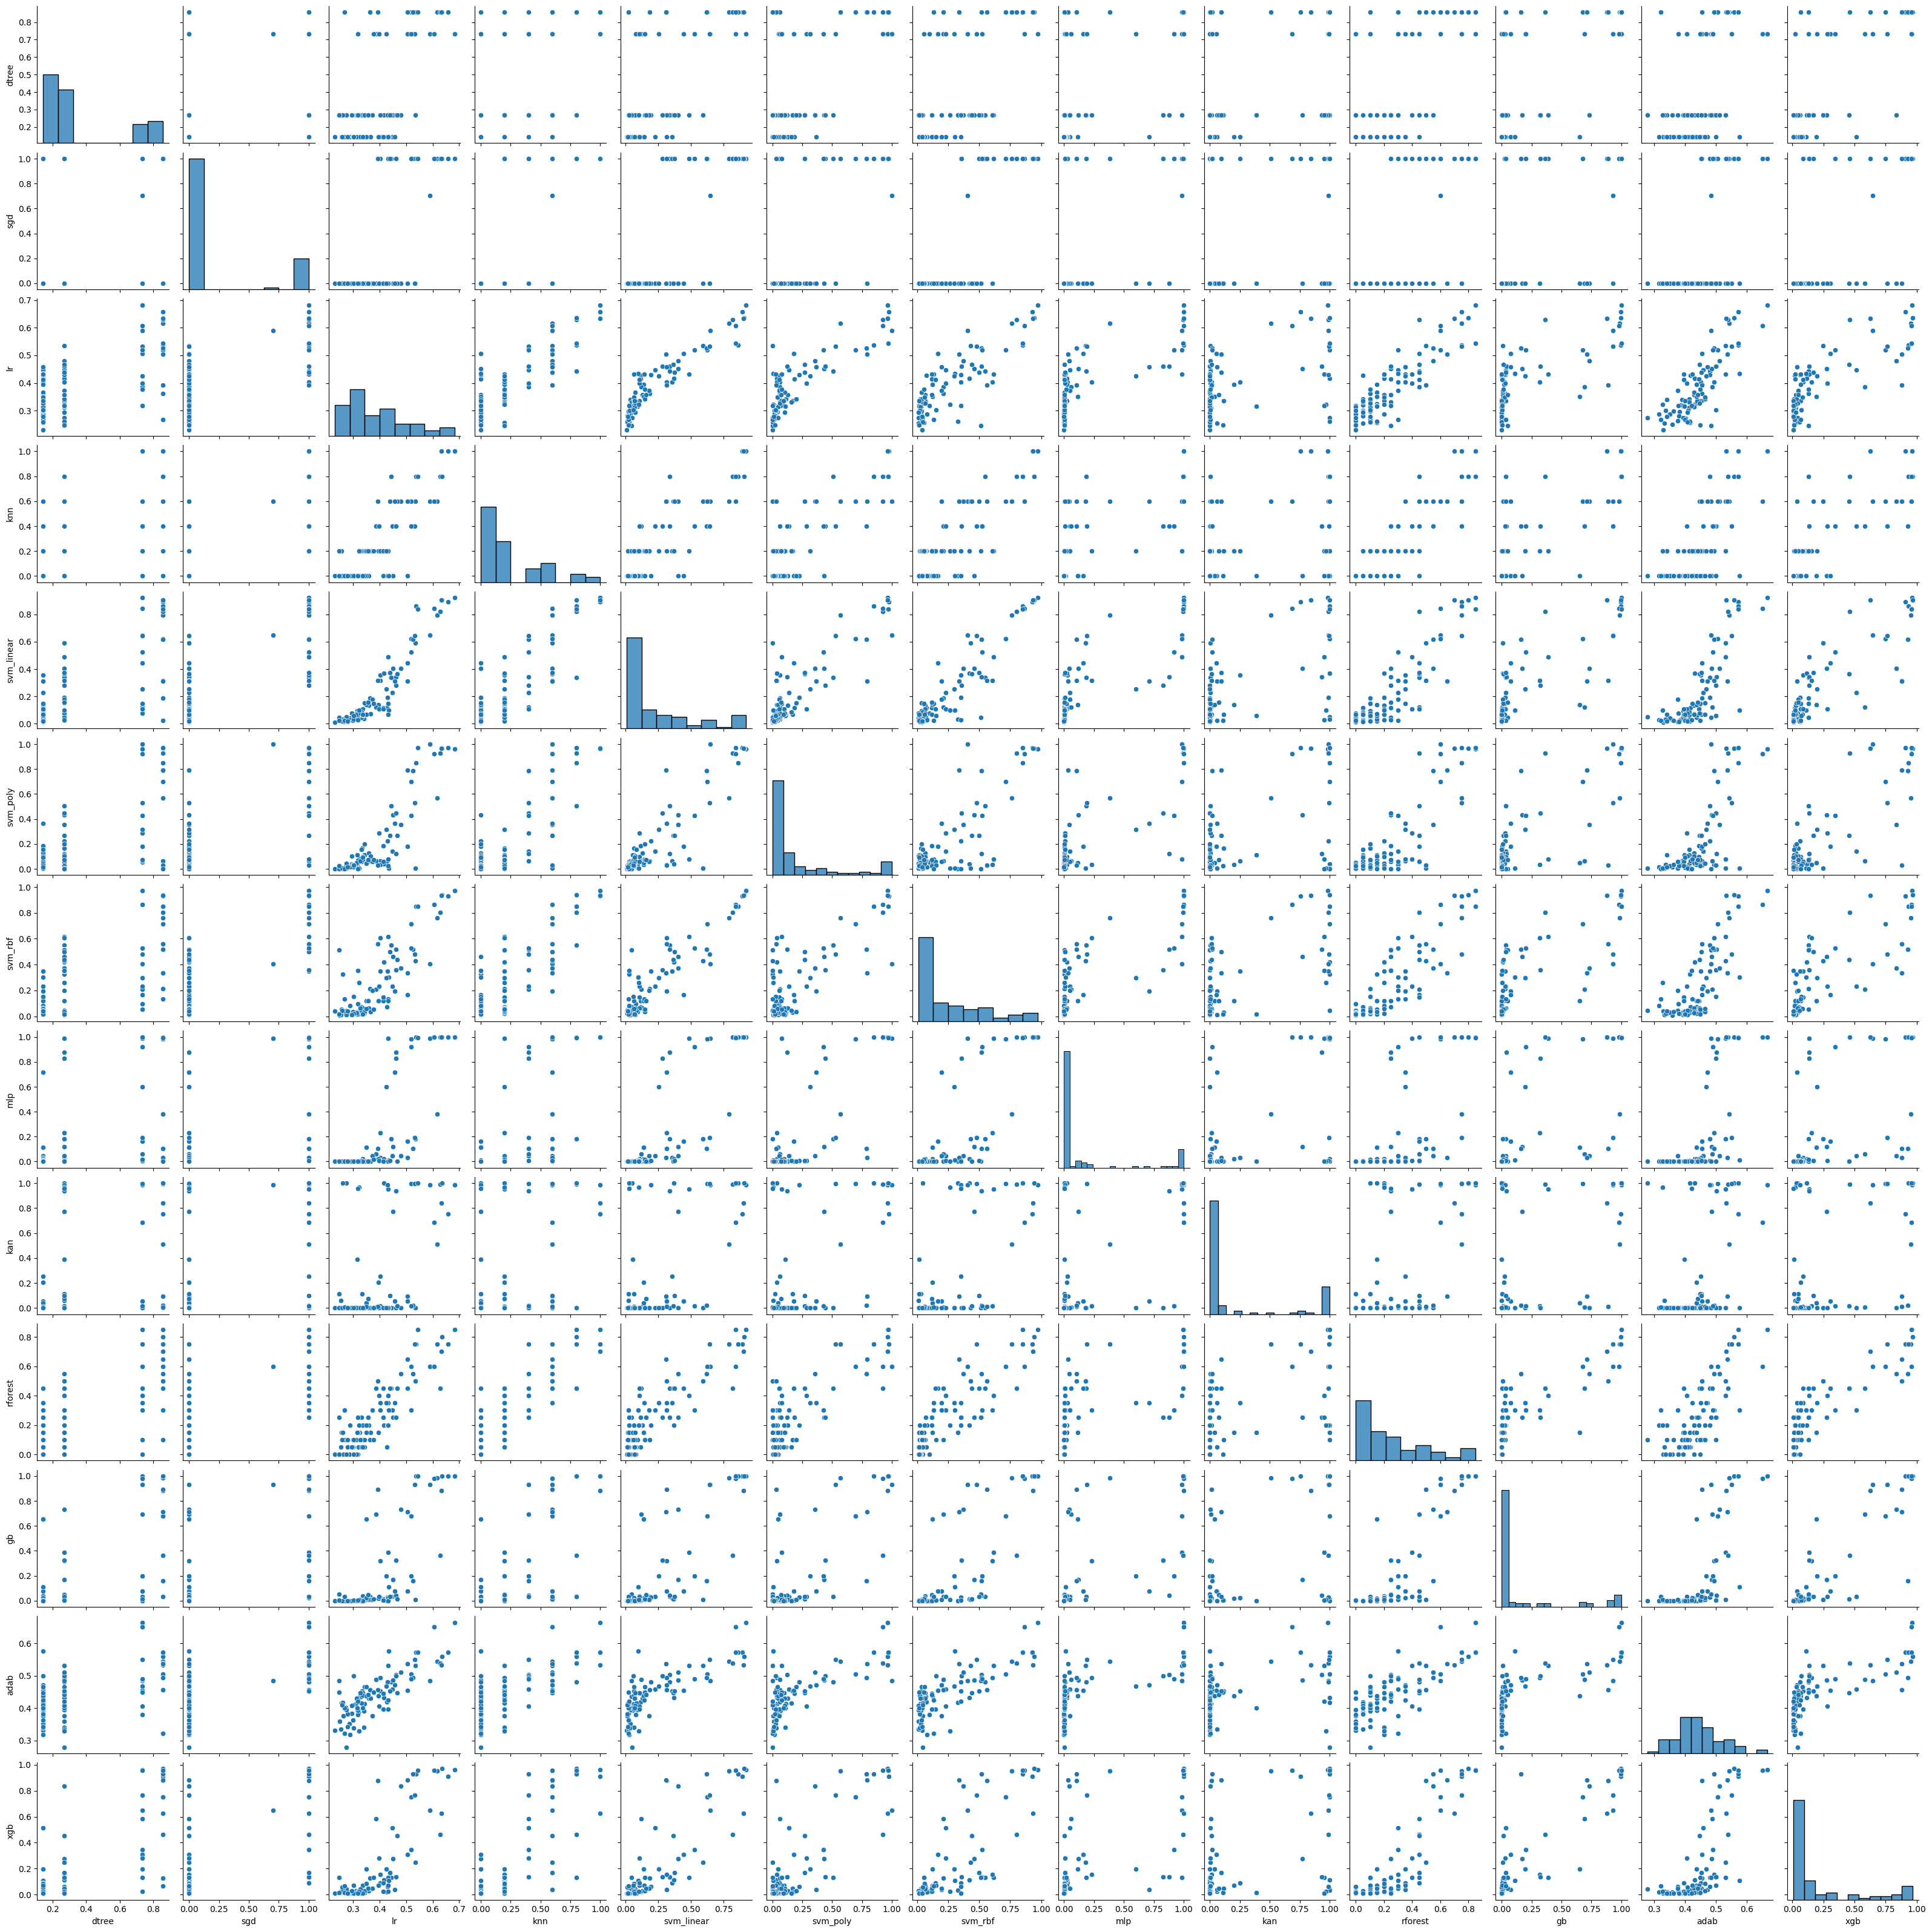

In [444]:
sns.pairplot(models_error)

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [48]:
def group_search_help(df: pd.DataFrame, min_score: int, models: list | set = None, base_group: list = []):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    if len(base_group) == 0:
        base_group, models = models[:1], models[1:]

    output_groups = []

    for m in models:
        check = True
        for bg in base_group:
            corr = df.at[bg, m]
            if np.isnan(corr) or corr < min_score:
                check = False
                break
        if check:
            temp = models.copy()
            temp.remove(m)
            output_groups.append(
                group_search_help(df, min_score, temp, base_group + [m])
            )

    if len(output_groups) == 0:
        return base_group

    return output_groups

def group_search(df: pd.DataFrame, min_score: int, models: list = None):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    # Corrige valores abaixo do min_score
    df = df.map(lambda x: np.nan if x < min_score else x)

    raw_groups = []
    for i in range(len(models)):
        raw_groups.append(group_search_help(df, min_score, models[i:]))

    return remove_subgroups(flatten_groups(raw_groups))
    
def flatten_groups(nested_list):
    flat_list = []

    def _flatten(item):
        if isinstance(item[0], list):
            for subitem in item:
                _flatten(subitem)
        else:
            flat_list.append(sorted(item))  # ordena para facilitar comparação de subconjuntos

    _flatten(nested_list)
    return flat_list

def remove_subgroups(groups:list):
    # Remove duplicatas (grupos com os mesmos elementos, em qualquer ordem)
    seen = set()
    unique_groups = []
    for g in groups:
        frozen = frozenset(g)
        if frozen not in seen:
            seen.add(frozen)
            unique_groups.append(g)

    # Agora removemos subconjuntos estritos
    filtered_groups = []
    for g in unique_groups:
        is_subset = False
        for other in unique_groups:
            if g != other and set(g).issubset(set(other)):
                is_subset = True
                break
        if not is_subset:
            filtered_groups.append(g)

    return filtered_groups

Spearman:

In [64]:
min_score = corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score)

groups['true_assessor_train'] = group_search(pred_corrls, min_score)
groups['true_assessor_train']

Min_score: 0.8005676090025124


[['dtree'],
 ['sgd'],
 ['lr', 'mlp', 'svm_linear'],
 ['lr', 'svm_poly'],
 ['lr', 'rforest'],
 ['knn'],
 ['gb', 'mlp', 'svm_linear', 'svm_rbf', 'xgb'],
 ['gb', 'rforest', 'svm_rbf', 'xgb'],
 ['adab', 'gb', 'mlp', 'xgb'],
 ['kan']]

Kendall:

In [59]:
min_score = corrls_values['corr'].quantile(0.75)

print('Min_score:', min_score)

groups['true_assessor_train'] = group_search(pred_corrls, min_score)
groups['true_assessor_train']

Min_score: 0.6438099044790425


[['dtree'],
 ['sgd'],
 ['knn', 'lr', 'mlp', 'svm_linear'],
 ['knn', 'lr', 'rforest'],
 ['lr', 'svm_poly'],
 ['gb', 'mlp', 'svm_linear', 'xgb'],
 ['gb', 'mlp', 'svm_rbf'],
 ['gb', 'rforest', 'svm_rbf'],
 ['kan'],
 ['gb', 'rforest', 'xgb'],
 ['adab', 'gb']]

Pearson:

In [70]:
min_score = corrls_values['corr'].quantile(0.85)

print('Min_score:', min_score)

groups['true_assessor_train'] = group_search(pred_corrls, min_score)
groups['true_assessor_train']

Min_score: 0.8511471707245248


[['dtree'],
 ['sgd'],
 ['lr', 'svm_linear', 'svm_poly'],
 ['lr', 'rforest', 'svm_linear'],
 ['knn', 'rforest', 'svm_linear'],
 ['rforest', 'svm_linear', 'svm_rbf'],
 ['rforest', 'svm_linear', 'xgb'],
 ['mlp'],
 ['kan'],
 ['gb', 'xgb'],
 ['adab']]

In [107]:
#min_score = temp.quantile(0.75)
#print('Min_score:', min_score)
#groups['true_assessor_train'] = group_search(phik_overview, min_score)
#groups['true_assessor_train']

Min_score: 0.8858903858852721


[['dtree', 'lr'],
 ['sgd', 'svm_poly'],
 ['sgd', 'svm_rbf'],
 ['lr', 'rforest', 'svm_linear', 'svm_poly'],
 ['knn', 'rforest', 'svm_poly'],
 ['rforest', 'svm_poly', 'xgb'],
 ['mlp'],
 ['kan'],
 ['gb', 'rforest', 'xgb'],
 ['adab']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [390]:
#def nmse(y_true, y_pred):
#    '''Normalized Mean Squared Error'''
#    #mean_squared = mse(y_true, y_pred)
#    sum1, sum2 = 0, 0
#    n = len(y_true)
#    y_mean = y_true.mean()
#    for i in range(n):
#        sum1 += ((y_pred[i] - y_true[i])**2)
#        sum2 += ((y_mean - y_true[i])**2)
#    return sum1 / sum2 #* mean_squared

def nmse(y_true, y_pred, sample_weight=None, 
         multioutput="uniform_average"):
    mse_error = mse(y_true, y_pred, sample_weight=sample_weight, multioutput="raw_values")
    variance = np.var(np.asarray(y_true), axis=0)
    
    if 0 in variance.flatten():
        raise ValueError("A variância dos valores reais é zero; não é possível normalizar.")
    
    output_errors = mse_error / variance
    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def nmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)    
    error = {}
    for c in y_true.columns:
        error[c] = nmse(y_true[c], y_pred[c])
    return error

def mse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = ((y_true[c] - y_pred[c])**2).mean()
    return error

def rmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (((y_true[c] - y_pred[c])**2).mean())**0.5
    return error

def mae_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (abs(y_true[c] - y_pred[c])).mean()
    return error

In [127]:
models_error

dtree  sgd        lr  knn  svm_linear  svm_poly   svm_rbf       mlp  \
0   0.733333  1.0  0.682079  1.0    0.922145  0.962813  0.973425  0.999623   
1   0.142857  0.0  0.447787  0.4    0.227860  0.138998  0.232454  0.047386   
2   0.857143  1.0  0.657508  1.0    0.893359  0.972718  0.928617  0.999808   
3   0.266667  0.0  0.250467  0.0    0.027827  0.012555  0.008787  0.000004   
4   0.266667  0.0  0.315945  0.0    0.093144  0.034455  0.035390  0.004420   
..       ...  ...       ...  ...         ...       ...       ...       ...   
90  0.733333  0.0  0.424479  0.2    0.254646  0.316882  0.297662  0.599503   
91  0.266667  1.0  0.438634  0.6    0.373980  0.267533  0.500000  0.006898   
92  0.733333  1.0  0.518547  0.4    0.525712  0.426520  0.525849  0.921146   
93  0.266667  0.0  0.317631  0.0    0.025760  0.000017  0.352756  0.000035   
94  0.142857  0.0  0.279323  0.0    0.016492  0.013261  0.038701  0.000003   

         kan  rforest        gb      adab       xgb  
0   0.987163     0.85  0.999621  0.665205  0.962335  
1   0.002060     0.30  0.033610  0.459122  0.513467  
2   0.756189     0.75  0.998479  0.572783  0.909080  
3   0.000053     0.00  0.000378  0.358806  0.017478  
4   0.001035     0.10  0.000414  0.395542  0.020938  
..       ...      ...       ...       ...       ...  
90  0.000266     0.35  0.198490  0.468653  0.196135  
91  0.096774     0.45  0.034072  0.453278  0.167693  
92  0.016649     0.30  0.200049  0.489528  0.344218  
93  0.956685     0.25  0.002058  0.421217  0.011064  
94  0.000442     0.10  0.000028  0.342719  0.008357  

[95 rows x 13 columns]

In [128]:
#df_assessor = pd.concat([Xb_test, yb_test], axis=1)

#y_pred = dtree.predict(Xa_test)

model_names = list(performs.keys())

Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

#df_assessor[model_names] = np.NaN

#for i in range(len(models)):
#    
#    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
#        y_pred = models[i].predict_proba(Xb_test)
#    else:
#        y_pred = models[i].predict_proba(Xb_test_norm)
#
#    #pred_hits[model_names[i]] = np.argmax(y_pred, axis=1) != yb_test
#    # np.arange vai retornar os índices das duplas de probabilidades.
#    # yb_test vai epecificar o índice (classe) da probabilidade da classe correta
#    # dentro de cada dupla de probabilidades.
#    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]

ya_train.head()

dtree  sgd        lr  knn  svm_linear  svm_poly   svm_rbf       mlp  \
0  0.733333  1.0  0.682079  1.0    0.922145  0.962813  0.973425  0.999623   
1  0.142857  0.0  0.447787  0.4    0.227860  0.138998  0.232454  0.047386   
2  0.857143  1.0  0.657508  1.0    0.893359  0.972718  0.928617  0.999808   
3  0.266667  0.0  0.250467  0.0    0.027827  0.012555  0.008787  0.000004   
4  0.266667  0.0  0.315945  0.0    0.093144  0.034455  0.035390  0.004420   

        kan  rforest        gb      adab       xgb  
0  0.987163     0.85  0.999621  0.665205  0.962335  
1  0.002060     0.30  0.033610  0.459122  0.513467  
2  0.756189     0.75  0.998479  0.572783  0.909080  
3  0.000053     0.00  0.000378  0.358806  0.017478  
4  0.001035     0.10  0.000414  0.395542  0.020938

In [129]:
Xa_train.head()

age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
115  64.0  1.0         4.0           128.0        263.0          0.0   
131  61.0  1.0         3.0           150.0        243.0          1.0   
12   58.0  0.0         2.0           136.0        319.0          1.0   
40   60.0  1.0         4.0           145.0        282.0          0.0   
51   54.0  1.0         4.0           110.0        239.0          0.0   

     eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
115             0.0           105.0          1.0      0.2         2.0   
131             0.0           137.0          1.0      1.0         2.0   
12              2.0           152.0          0.0      0.0         1.0   
40              2.0           142.0          1.0      2.8         2.0   
51              0.0           126.0          1.0      2.8         2.0   

     major_vessels  thal  
115            1.0   7.0  
131            0.0   3.0  
12             2.0   3.0  
40             2.0   7.0  
51             1.0   7.0

In [130]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

dtree  sgd        lr  knn  svm_linear  svm_poly   svm_rbf       mlp  \
0  0.266667  1.0  0.507978  0.6    0.791612  0.970153  0.759217  0.930490   
1  0.266667  1.0  0.435416  0.2    0.534103  0.177594  0.182750  0.373908   
2  0.266667  0.0  0.474333  0.4    0.433177  0.547447  0.461346  0.064477   
3  0.266667  0.0  0.335498  0.2    0.098290  0.048227  0.298621  0.004582   
4  0.857143  0.0  0.484341  0.2    0.500000  0.514898  0.571390  0.731841   

        kan  rforest        gb      adab       xgb  
0  0.013227     0.55  0.636015  0.539770  0.917054  
1  0.999897     0.25  0.324749  0.505585  0.599195  
2  0.193748     0.60  0.561520  0.512386  0.478614  
3  0.000673     0.50  0.159529  0.472193  0.402046  
4  0.783275     0.40  0.747523  0.522342  0.484199

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

In [ ]:
#models_error2 = pd.DataFrame()
#
#for i in range(len(models)):
#    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
#        y_pred = models[i].predict(Xa_test)
#    else:
#        y_pred = models[i].predict(Xa_test_norm)
#        
#    models_error2[model_names[i]] = ya_test_tgt - y_pred
#
#models_error2

dtree    sgd     lr    knn  svm_linear  svm_poly  svm_rbf    mlp    kan  \
0   False   True   True   True        True      True     True   True  False   
1   False   True  False  False        True     False    False  False   True   
2   False  False  False  False       False      True    False  False  False   
3   False  False  False  False       False     False    False  False  False   
4    True  False  False  False        True      True     True   True   True   
..    ...    ...    ...    ...         ...       ...      ...    ...    ...   
76  False  False  False  False       False     False    False  False  False   
77  False  False  False  False       False     False    False  False  False   
78   True   True  False  False        True     False    False  False   True   
79   True   True   True  False        True      True    False   True  False   
80  False  False  False  False       False     False    False  False  False   

    rforest     gb   adab    xgb  
0      True   True   True   True  
1     False  False   True   True  
2      True   True   True  False  
3      True  False  False  False  
4     False   True   True  False  
..      ...    ...    ...    ...  
76    False  False  False  False  
77    False  False  False  False  
78    False  False  False   True  
79     True  False  False   True  
80    False  False  False  False  

[81 rows x 13 columns]

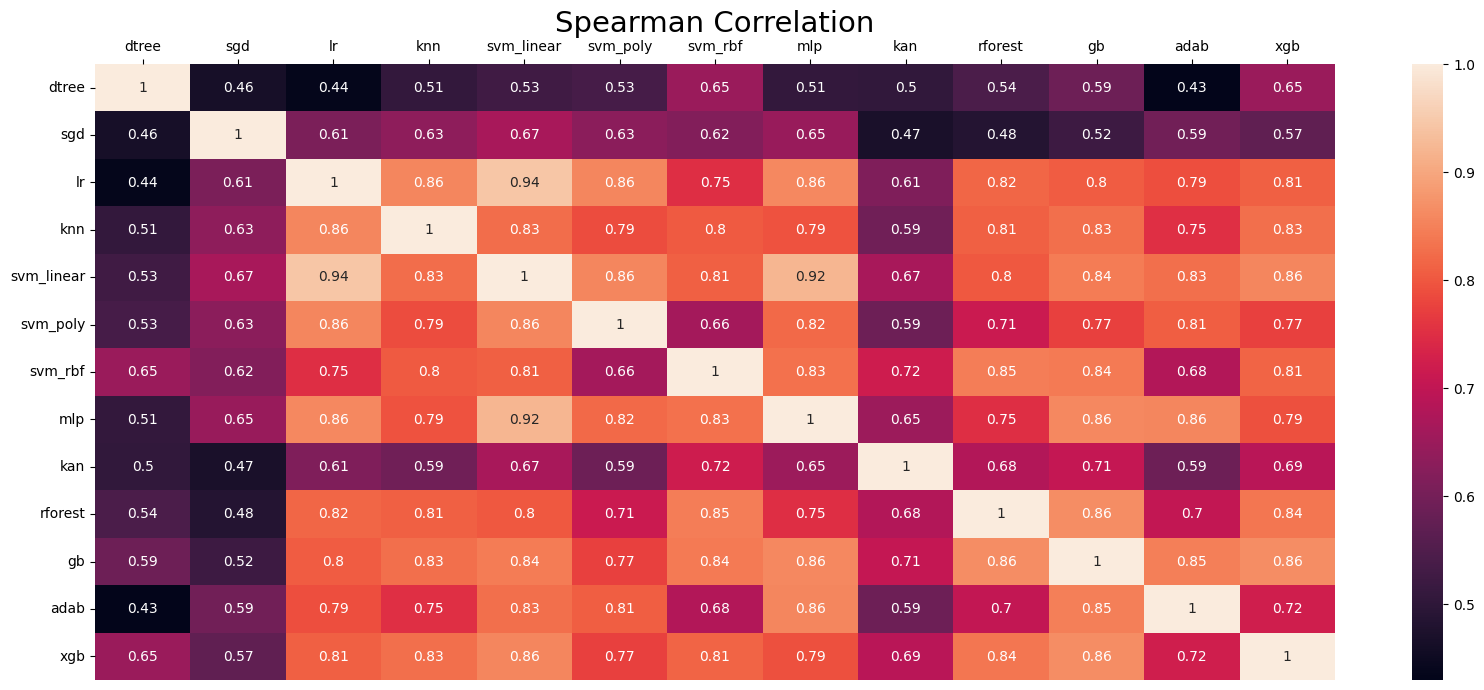

In [ ]:
#pred_corrls2 = pd.DataFrame(columns=model_names, index=model_names, dtype=float)
#
#for m in model_names:
#    for n in model_names:
#        pred_corrls2.at[m,n] = phi_coef(models_error2[m], models_error2[n])

pred_corrls2 = ya_test.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()

In [132]:
corrls_values2 = pd.Series(pred_corrls2.values.reshape((169,)))
corrls_values2.describe()

count    169.000000
mean       0.736702
std        0.146918
min        0.429439
25%        0.627849
50%        0.774752
75%        0.841531
max        1.000000
dtype: float64

<Axes: >

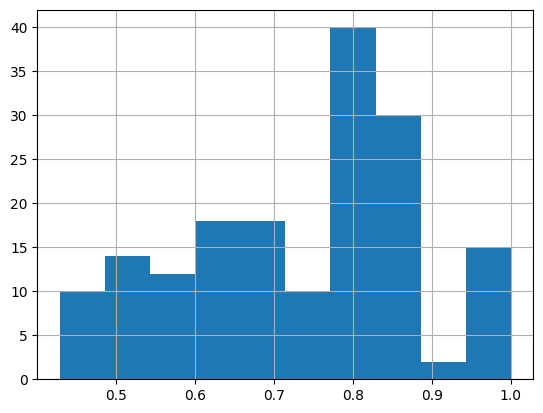

In [133]:
corrls_values2.hist()

In [134]:
min_score2 = corrls_values2.quantile(0.75)

print('Min_score:', min_score2)

groups['true_assessor_test'] = group_search(pred_corrls2, min_score2)
groups['true_assessor_test']

Min_score: 0.8415311653116531


[['dtree'],
 ['sgd'],
 ['knn', 'lr'],
 ['lr', 'svm_linear', 'svm_poly'],
 ['lr', 'mlp', 'svm_linear'],
 ['gb', 'mlp', 'svm_linear'],
 ['gb', 'svm_linear', 'xgb'],
 ['gb', 'rforest', 'svm_rbf'],
 ['adab', 'gb', 'mlp'],
 ['kan']]

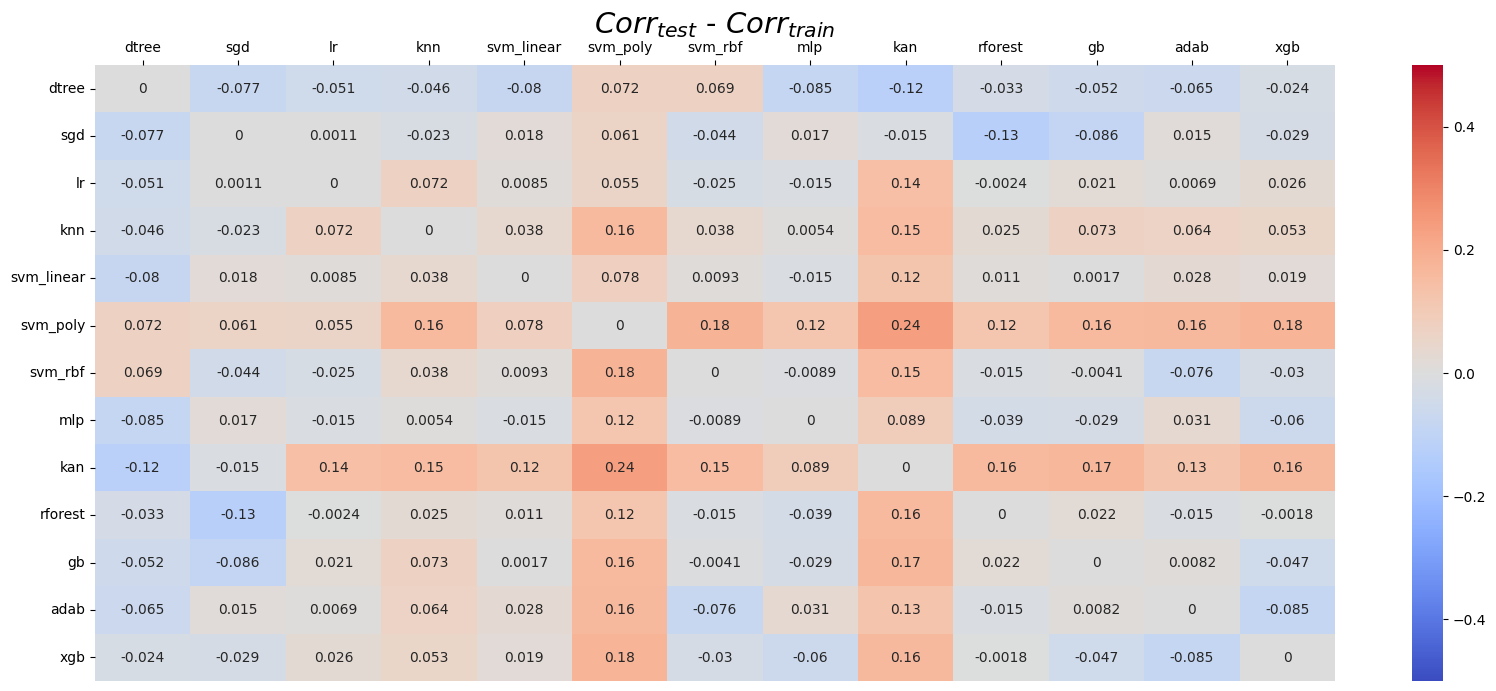

In [ ]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = pred_corrls2-pred_corrls

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Globais

### Regressor Chain
(RC)

In [135]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.1s
[Chain] ................ (12 of 13) Processing order 11, total=   0.1s
[Chain] ................ (13 of 13) Processing order 12, total=   0.1s


In [310]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [311]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0829
RMSE: 0.2713
MAE: 0.2098


dtree       sgd       lr       knn  svm_linear  svm_poly  \
regchain      0.07075  0.144675  0.00802  0.088693    0.063051  0.085074   
multi-output      NaN       NaN      NaN       NaN         NaN       NaN   
individual        NaN       NaN      NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb     adab  \
regchain      0.076151  0.119054  0.155764  0.049132  0.121251  0.00383   
multi-output       NaN       NaN       NaN       NaN       NaN      NaN   
individual         NaN       NaN       NaN       NaN       NaN      NaN   

                   xgb  
regchain      0.091771  
multi-output       NaN  
individual         NaN

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

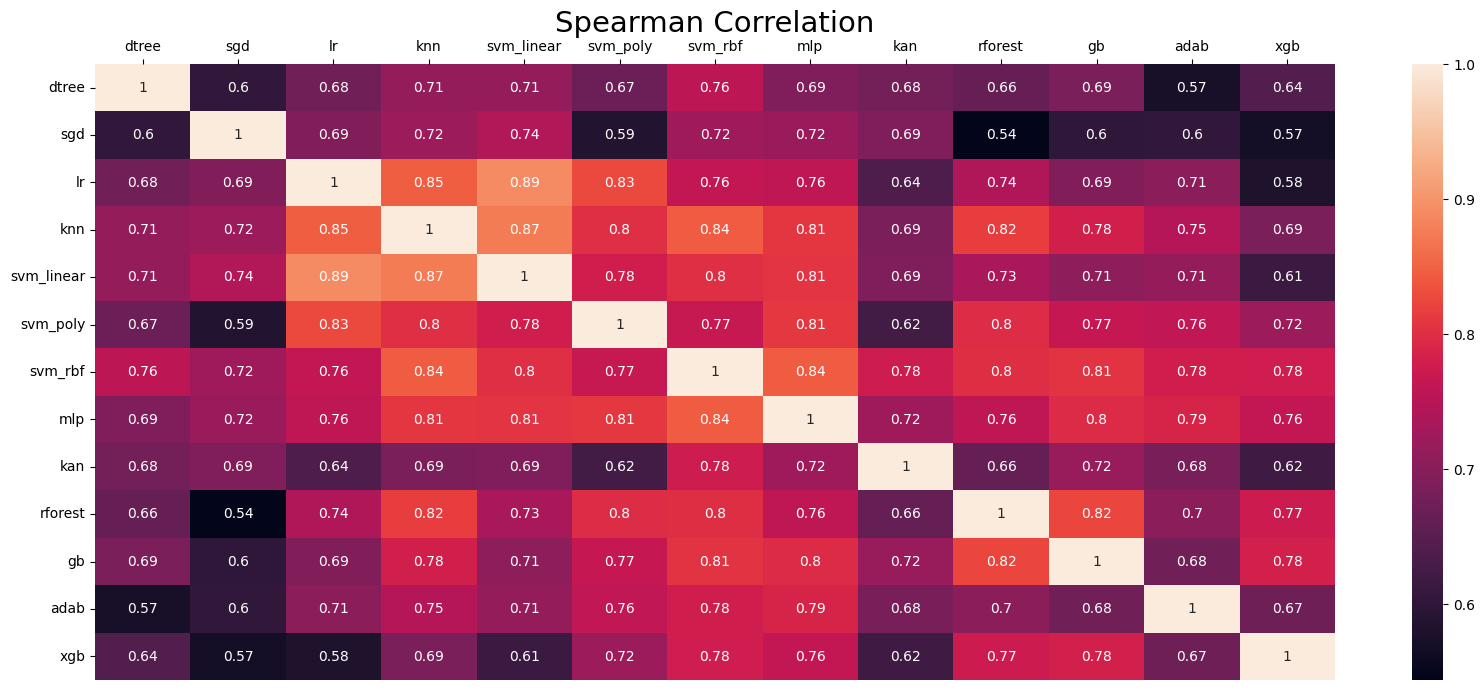

In [ ]:
#y_pred = pd.DataFrame(regchain.predict(Xa_train), columns=model_names, index=Xa_train.index)
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
#y_pred = y_pred.map(lambda x: 1 - round(x))

regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('pearson') 

#for m in model_names:
#    for n in model_names:
#        regchain_corrls.at[m,n] = phi_coef((y_pred[m]!=ya_train_tgt), (y_pred[n]!=ya_train_tgt))

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()

In [145]:
regchain_corrls_values = pd.Series(regchain_corrls.values.reshape((169,)))
regchain_corrls_values.describe()

count    169.000000
mean       0.746379
std        0.104099
min        0.544108
25%        0.685212
50%        0.740309
75%        0.800164
max        1.000000
dtype: float64

<Axes: >

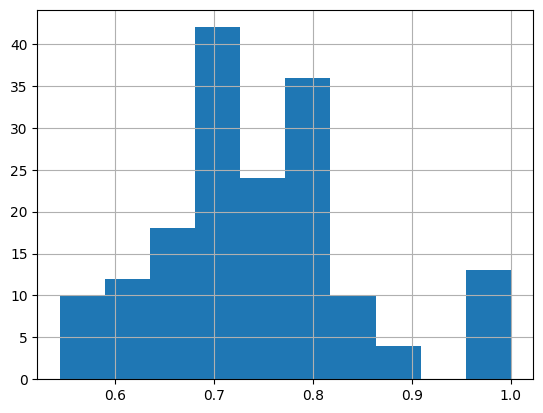

In [146]:
regchain_corrls_values.hist()

In [147]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_train'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_train']

Min_score: 0.8001637743742107


[['dtree'],
 ['sgd'],
 ['knn', 'lr', 'svm_linear'],
 ['knn', 'lr', 'svm_poly'],
 ['knn', 'mlp', 'svm_linear', 'svm_rbf'],
 ['knn', 'mlp', 'svm_poly'],
 ['knn', 'rforest', 'svm_rbf'],
 ['gb', 'rforest', 'svm_rbf'],
 ['kan'],
 ['adab'],
 ['xgb']]

Conjunto de Teste:

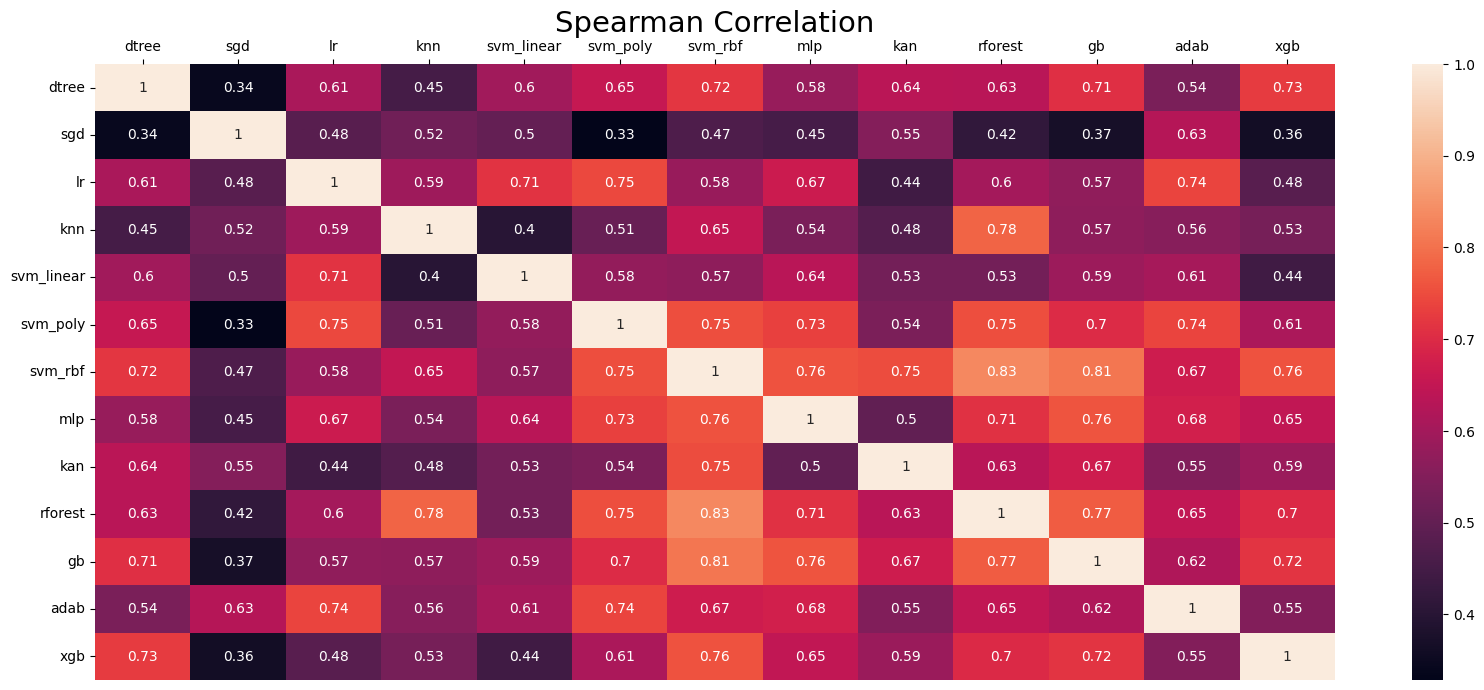

In [ ]:
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
#y_pred = y_pred.map(lambda x: 1 - round(x)) 

regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('pearson')

#for m in model_names:
#    for n in model_names:
#        regchain_corrls.at[m,n] = phi_coef((y_pred[m]!=ya_test_tgt), (y_pred[n]!=ya_test_tgt))

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()

In [149]:
regchain_corrls_values = pd.Series(regchain_corrls.values.reshape((169,)))
regchain_corrls_values.describe()

count    169.000000
mean       0.633446
std        0.154872
min        0.328334
25%        0.536922
50%        0.618022
75%        0.727078
max        1.000000
dtype: float64

<Axes: >

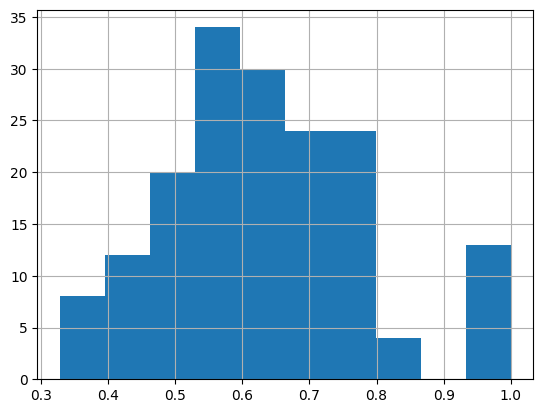

In [150]:
regchain_corrls_values.hist()

In [151]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_test'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_test']

Min_score: 0.7270776874435411


[['dtree', 'xgb'],
 ['sgd'],
 ['adab', 'lr', 'svm_poly'],
 ['knn', 'rforest'],
 ['svm_linear'],
 ['mlp', 'svm_poly', 'svm_rbf'],
 ['rforest', 'svm_poly', 'svm_rbf'],
 ['gb', 'mlp', 'svm_rbf'],
 ['kan', 'svm_rbf'],
 ['gb', 'rforest', 'svm_rbf'],
 ['svm_rbf', 'xgb']]

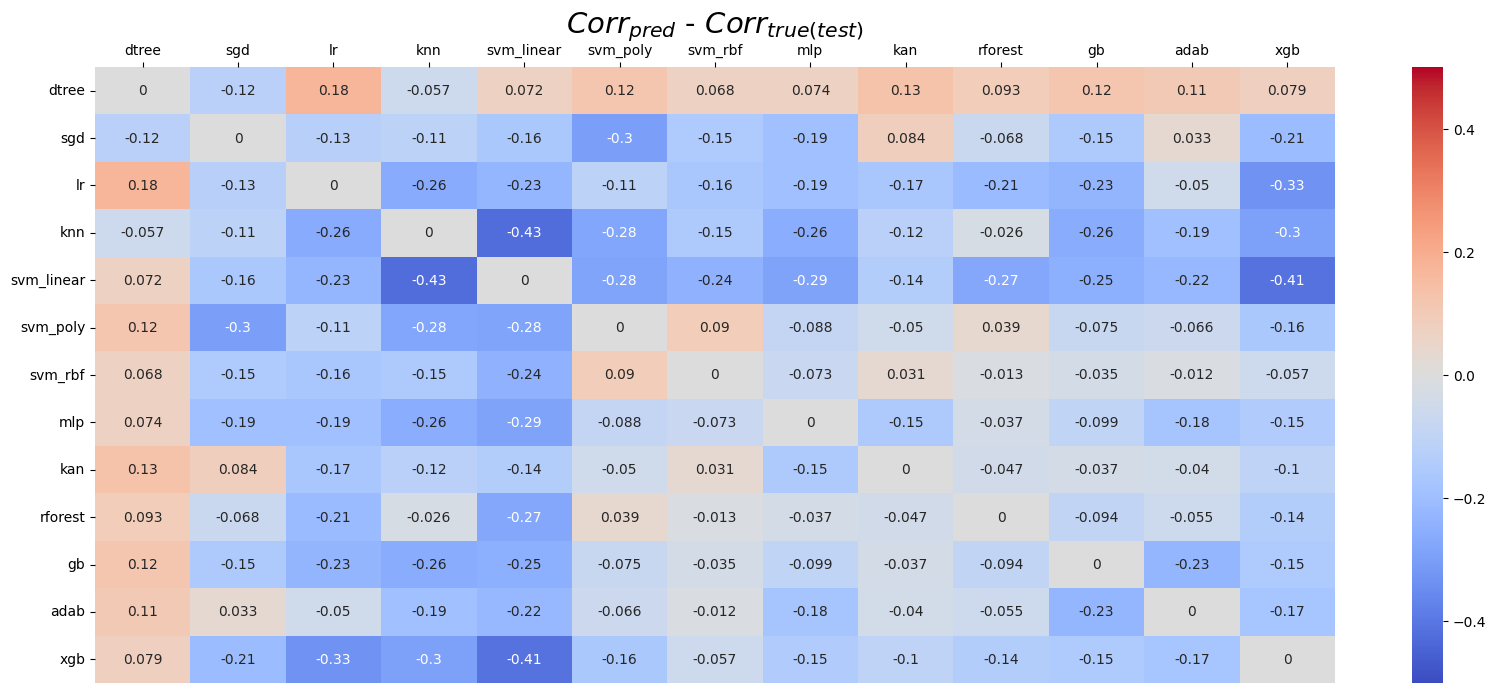

In [ ]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = regchain_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

### Multi-Output Regressor 
(ST)

In [152]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [312]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0882
RMSE: 0.2791
MAE: 0.2145


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.07075  0.144675  0.008020  0.088693    0.063051  0.085074   
multi-output  0.07075  0.149822  0.008231  0.085860    0.057809  0.081284   
individual        NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.076151  0.119054  0.155764  0.049132  0.121251  0.003830   
multi-output  0.081516  0.139950  0.160672  0.056684  0.143984  0.003806   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.091771  
multi-output  0.106339  
individual         NaN

#### Análise das correlações

Conjunto de Treinamento:

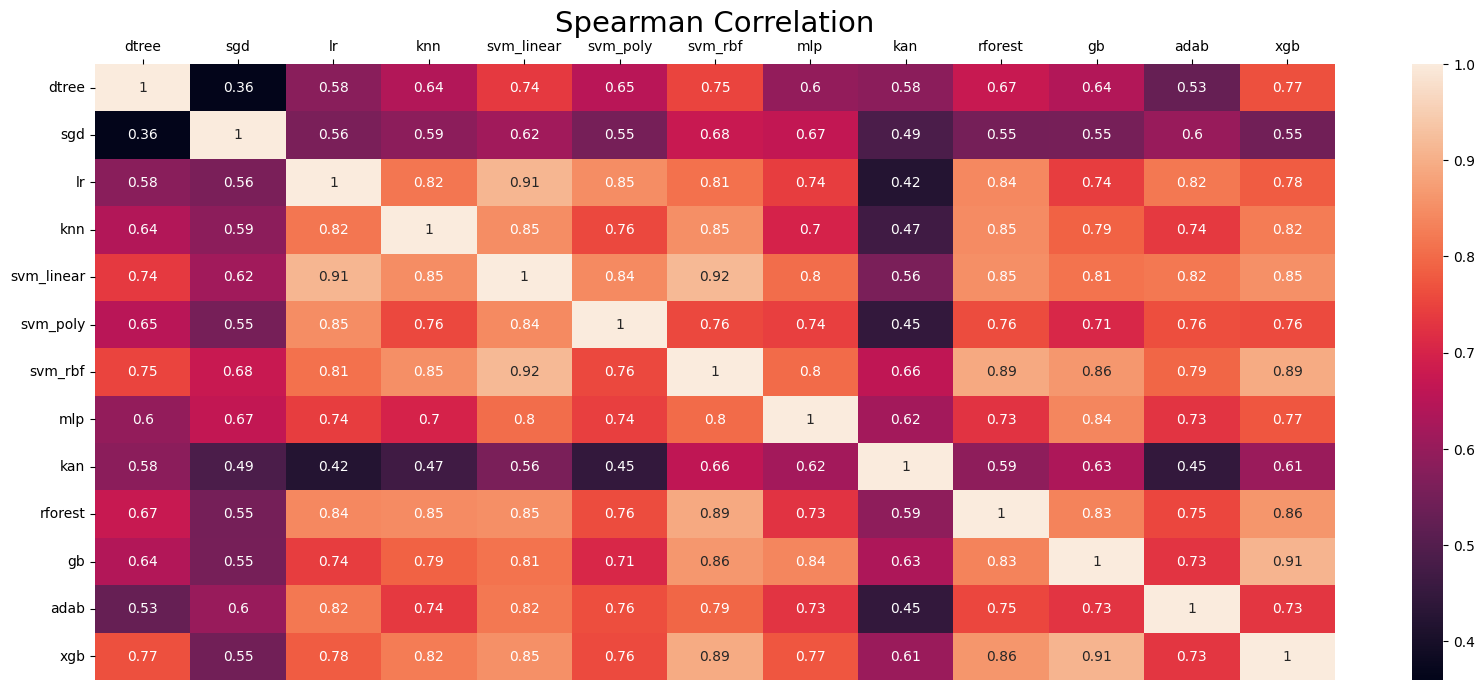

In [ ]:
#y_pred = pd.DataFrame(mor.predict(Xa_test), columns=model_names, index=Xa_train.index)
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
#y_pred = y_pred.map(lambda x: 1 - round(x)) 

mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('pearson')
#size_preds = len(ya_test)

#for m in model_names:
#    for n in model_names:
#        mor_corrls.at[m,n] = phi_coef((y_pred[m]!=ya_train_tgt), (y_pred[n]!=ya_train_tgt))

plt.figure(figsize=(20,8))
plt.title(r'pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()

In [156]:
mor_corrls_values = pd.Series(mor_corrls.values.reshape((169,)))
mor_corrls_values.describe()

count    169.000000
mean       0.734148
std        0.147277
min        0.359720
25%        0.619527
50%        0.753817
75%        0.842199
max        1.000000
dtype: float64

<Axes: >

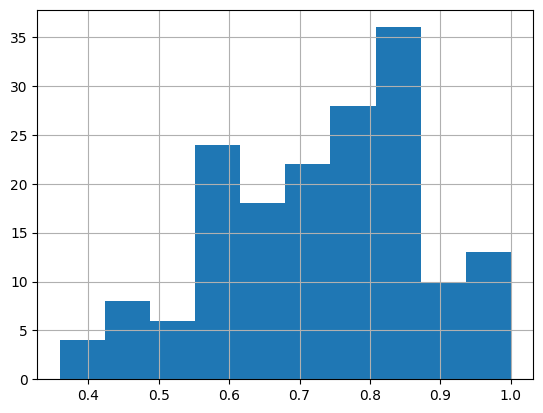

In [157]:
mor_corrls_values.hist()

In [158]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_train'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_train']

Min_score: 0.8421991958310101


[['dtree'],
 ['sgd'],
 ['lr', 'svm_linear', 'svm_poly'],
 ['lr', 'rforest', 'svm_linear'],
 ['knn', 'rforest', 'svm_linear', 'svm_rbf'],
 ['rforest', 'svm_linear', 'svm_rbf', 'xgb'],
 ['gb', 'svm_rbf', 'xgb'],
 ['mlp'],
 ['kan'],
 ['adab']]

Conjunto de Teste:

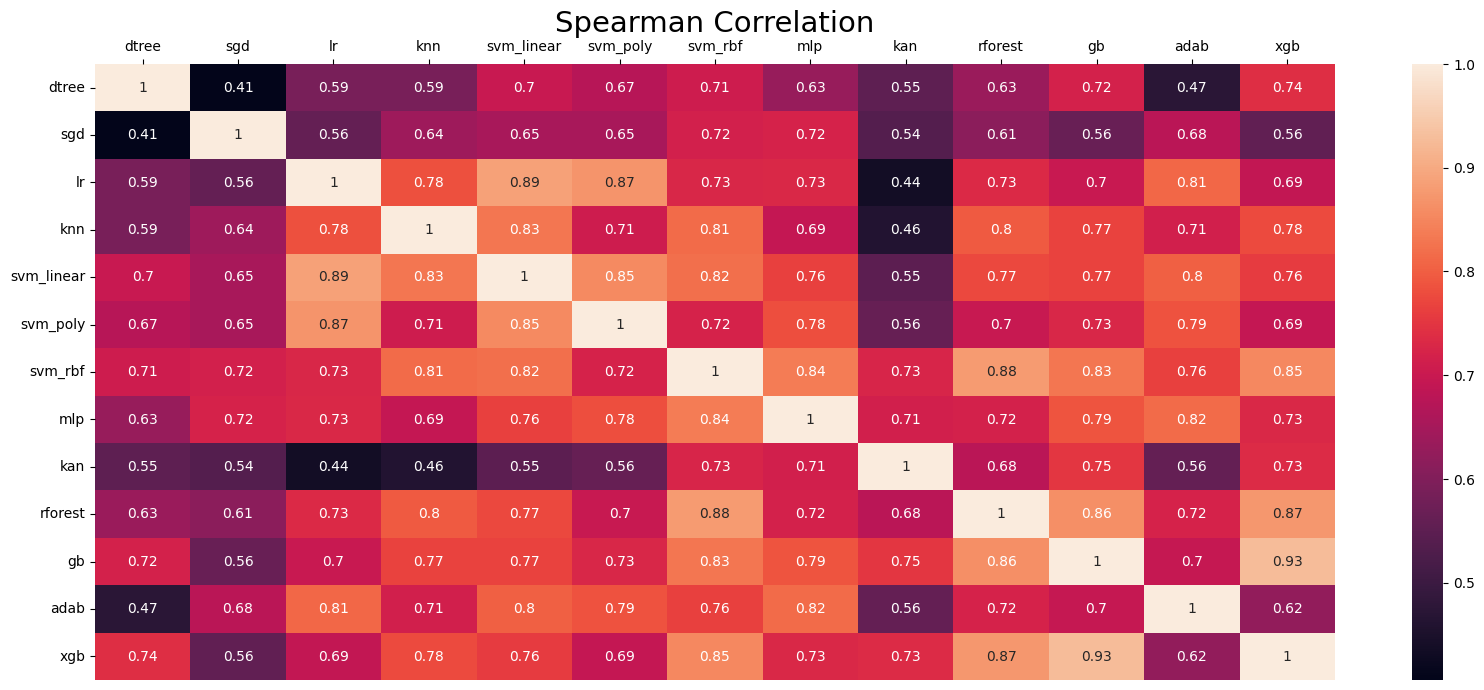

In [ ]:
#y_pred = pd.DataFrame(mor.predict(Xa_test), columns=model_names, index=Xa_test.index)
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
#y_pred = y_pred.map(lambda x: 1 - round(x)) 

mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('pearson')

#for m in model_names:
#    for n in model_names:
#        mor_corrls.at[m,n] = phi_coef((y_pred[m]!=ya_test_tgt), (y_pred[n]!=ya_test_tgt))

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()

In [287]:
mor_corrls_values = pd.Series(mor_corrls.values.reshape((169,)))
mor_corrls_values.describe()

count    169.000000
mean       0.732118
std        0.130774
min        0.406180
25%        0.674345
50%        0.727913
75%        0.811472
max        1.000000
dtype: float64

<Axes: >

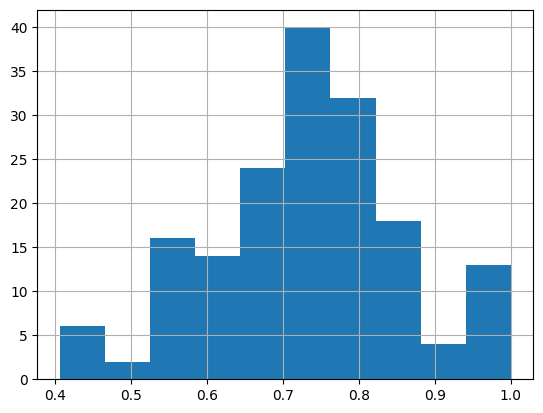

In [288]:
mor_corrls_values.hist()

In [289]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_test'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_test']

Min_score: 0.8114724480578139


[['dtree'],
 ['sgd'],
 ['lr', 'svm_linear', 'svm_poly'],
 ['adab', 'lr'],
 ['knn', 'svm_linear', 'svm_rbf'],
 ['mlp', 'svm_rbf'],
 ['gb', 'rforest', 'svm_rbf', 'xgb'],
 ['adab', 'mlp'],
 ['kan']]

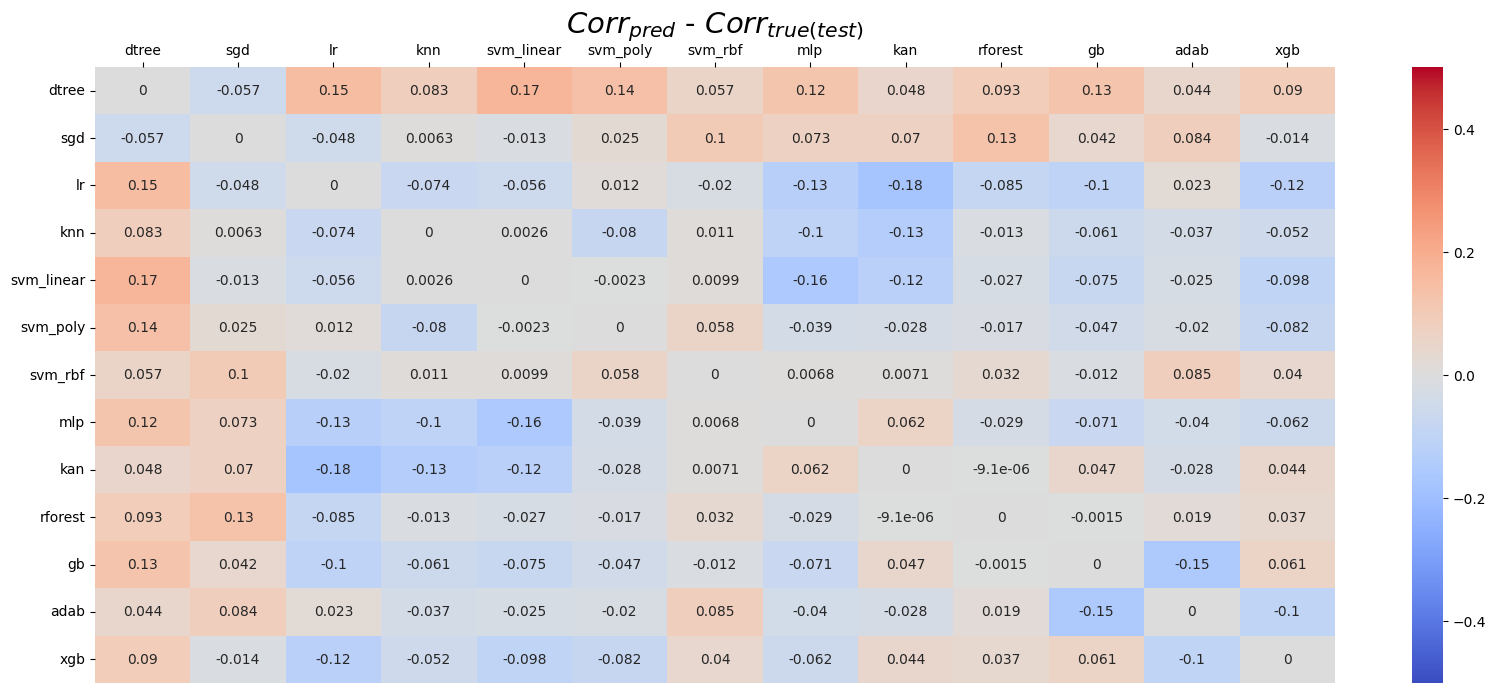

In [ ]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = mor_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Individuais

In [165]:
ind_assessors = {}
parameters['criterion'] = ['squared_error', 'poisson', 'friedman_mse']

for i in range(len(models)):
    g_search = GridSearchCV(RandomForestRegressor(random_state=seed), parameters, cv=5, n_jobs=-1)
    ind_assessors[model_names[i]] = g_search.fit(Xa_train, ya_train[model_names[i]]).best_estimator_
    print(f'[Assessor {i}] | Modelo Base: {model_names[i]} | Parâmetros: {g_search.best_params_}\nScore: {g_search.best_score_:.4f}\n')

[Assessor 0] | Modelo Base: dtree | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.0138

[Assessor 1] | Modelo Base: sgd | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 60, 'n_estimators': 20}
Score: -0.0743

[Assessor 2] | Modelo Base: lr | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Score: 0.0733

[Assessor 3] | Modelo Base: knn | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Score: -0.0641

[Assessor 4] | Modelo Base: svm_linear | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Score: -0.0029

[Assessor 5] | Modelo Base: svm_poly | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_sampl

In [313]:
metrics_indv = {'MSE':[], 'RMSE':[], 'MAE':[], 'NMSE':[]}

for m in model_names:
    y_pred = ind_assessors[m].predict(Xa_test)

    # Cálculo das métricas
    metrics_indv['MSE'].append(mse(ya_test[m], y_pred))
    metrics_indv['RMSE'].append(rmse(ya_test[m], y_pred))
    metrics_indv['MAE'].append(mae(ya_test[m], y_pred))
    metrics_indv['NMSE'].append(nmse(ya_test[m], y_pred))


    mse_df.at['individual',m] = mse(ya_test[m], y_pred)
    rmse_df.at['individual',m] = rmse(ya_test[m], y_pred)
    mae_df.at['individual',m] = mae(ya_test[m], y_pred)
    nmse_df.at['individual',m] = nmse(ya_test[m], y_pred)

for k in metrics_indv.keys():
    print(f'''{k}:
    - Média: {np.mean(metrics_indv[k]):.4f}
    - DP:    {np.std(metrics_indv[k]):.4f}''')

mse_df

MSE:
    - Média: 0.0873
    - DP:    0.0490
RMSE:
    - Média: 0.2777
    - DP:    0.1008
MAE:
    - Média: 0.2132
    - DP:    0.0778
NMSE:
    - Média: 0.9775
    - DP:    0.0796


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.070750  0.144675  0.008020  0.088693    0.063051  0.085074   
multi-output  0.070750  0.149822  0.008231  0.085860    0.057809  0.081284   
individual    0.067037  0.153973  0.008214  0.086627    0.057277  0.087024   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.076151  0.119054  0.155764  0.049132  0.121251  0.003830   
multi-output  0.081516  0.139950  0.160672  0.056684  0.143984  0.003806   
individual    0.081461  0.132565  0.168477  0.055164  0.138575  0.004350   

                   xgb  
regchain      0.091771  
multi-output  0.106339  
individual    0.093578

#### Análise das correlações

Conjunto de Treinamento:

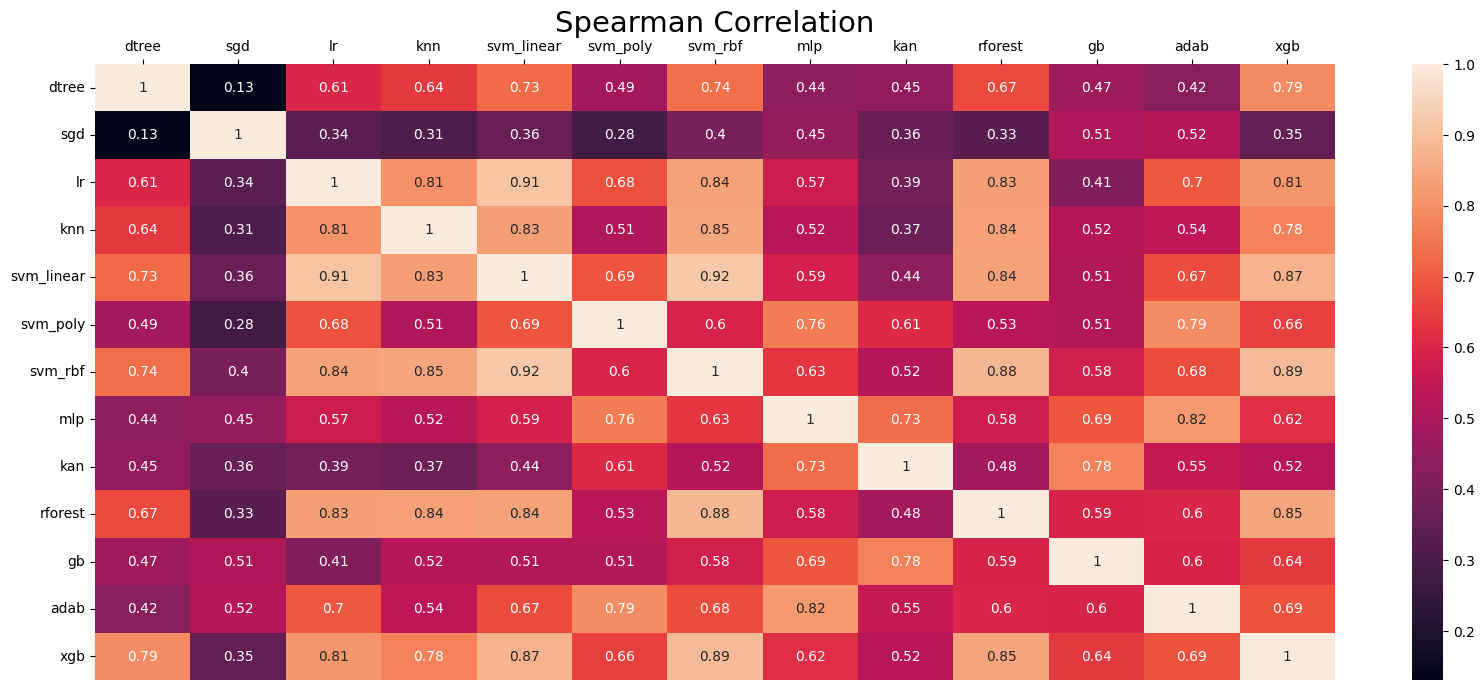

In [ ]:
#y_pred = pd.DataFrame(columns=model_names)

indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_train.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_train)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()

In [168]:
indass_corrls_values = pd.Series(indass_corrls.values.reshape((169,)))
indass_corrls_values.describe()

count    169.000000
mean       0.637849
std        0.198625
min        0.130830
25%        0.508851
50%        0.617161
75%        0.806166
max        1.000000
dtype: float64

<Axes: >

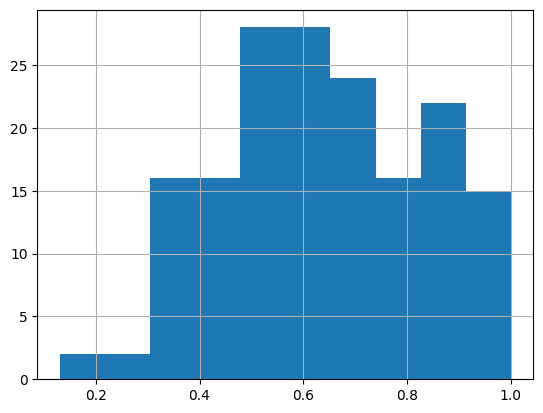

In [169]:
indass_corrls_values.hist()

In [170]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_train'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_train']

Min_score: 0.8061661214511198


[['dtree'],
 ['sgd'],
 ['knn', 'lr', 'rforest', 'svm_linear', 'svm_rbf'],
 ['lr', 'rforest', 'svm_linear', 'svm_rbf', 'xgb'],
 ['svm_poly'],
 ['adab', 'mlp'],
 ['kan'],
 ['gb']]

Conjunto de Teste:

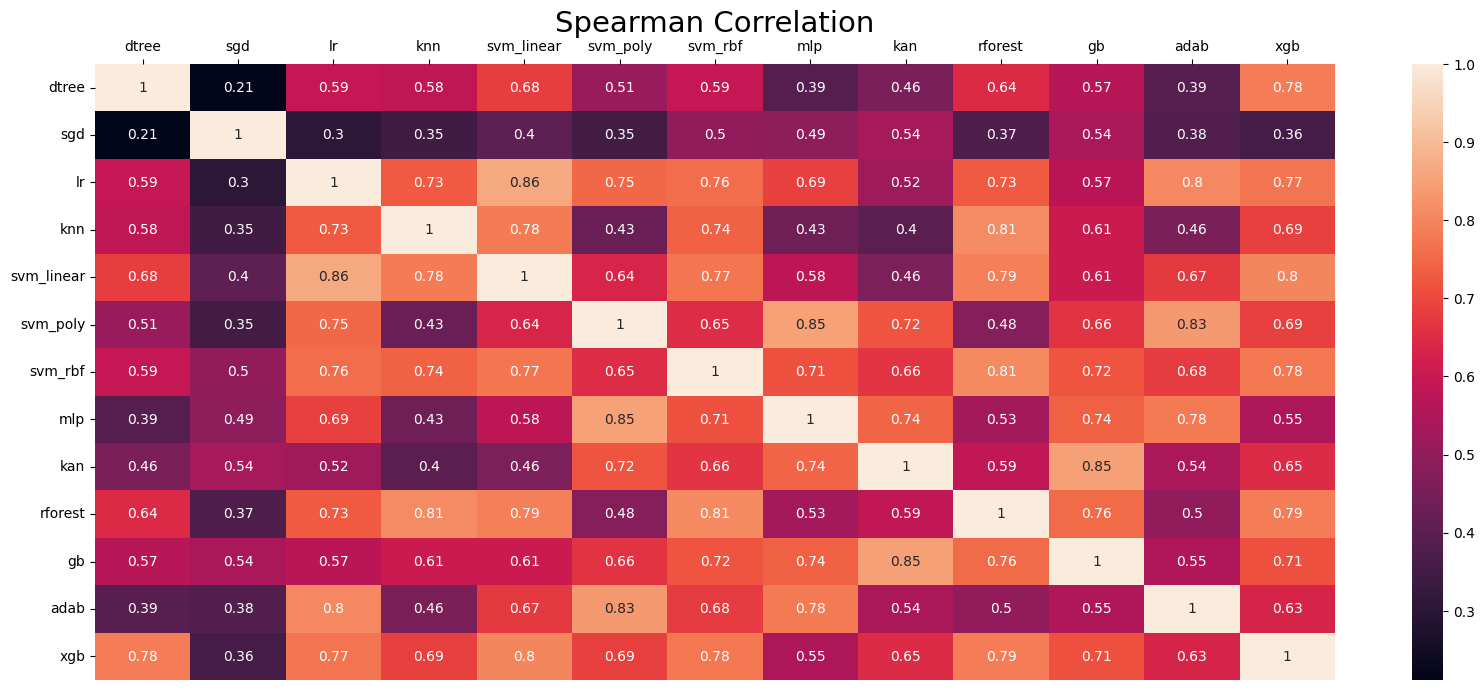

In [ ]:
indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_test.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_test)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()

In [172]:
indass_corrls_values = pd.Series(indass_corrls.values.reshape((169,)))
indass_corrls_values.describe()

count    169.000000
mean       0.644691
std        0.179695
min        0.211467
25%        0.522036
50%        0.662428
75%        0.772267
max        1.000000
dtype: float64

<Axes: >

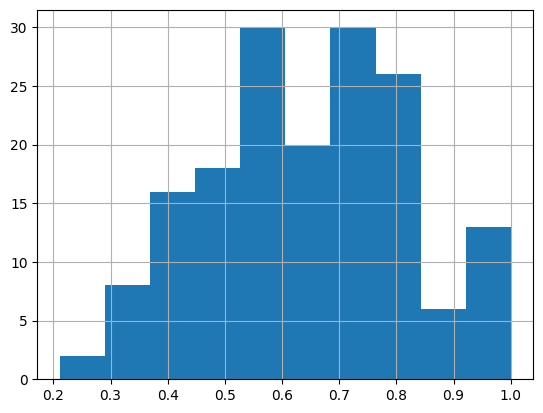

In [173]:
indass_corrls_values.hist()

In [174]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_test'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_test']

Min_score: 0.77226738934056


[['dtree', 'xgb'],
 ['sgd'],
 ['lr', 'svm_linear'],
 ['adab', 'lr'],
 ['knn', 'rforest', 'svm_linear'],
 ['rforest', 'svm_linear', 'svm_rbf', 'xgb'],
 ['adab', 'mlp', 'svm_poly'],
 ['gb', 'kan']]

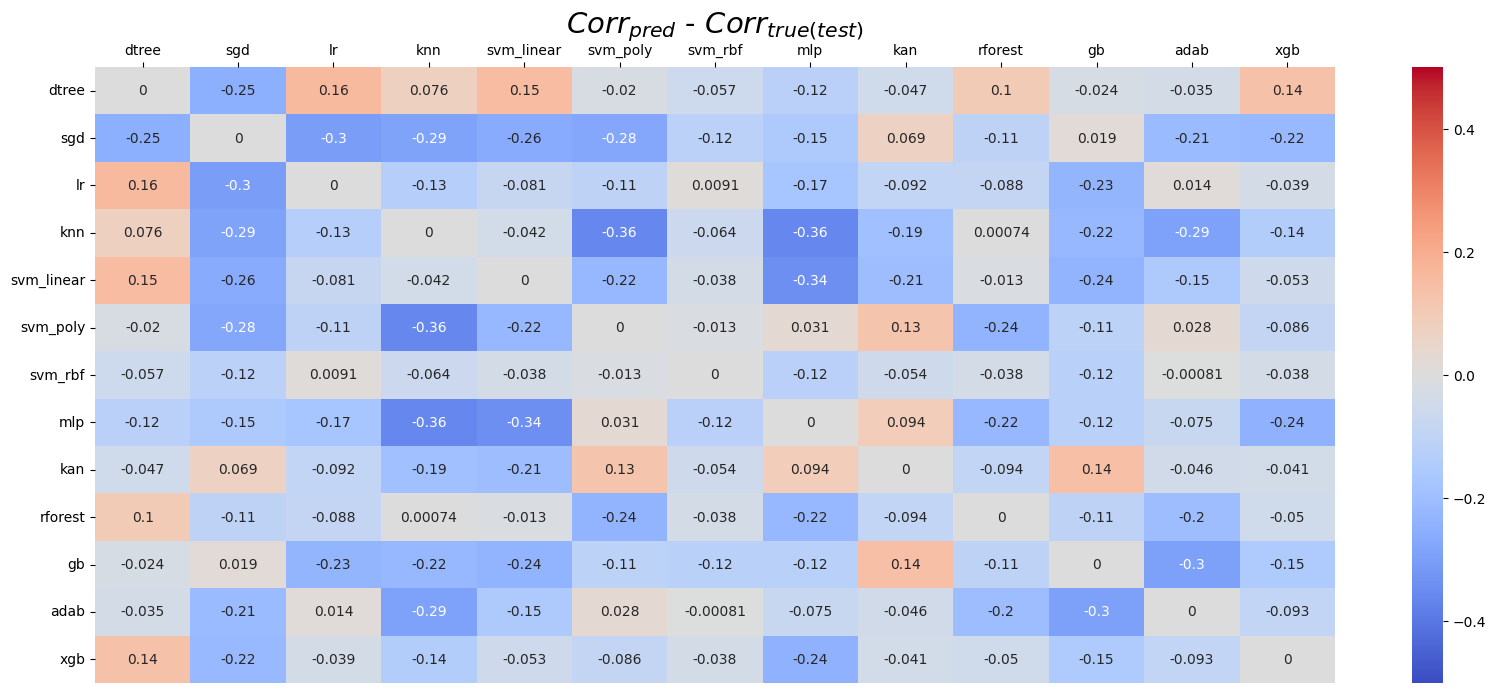

In [ ]:
#pred_corrls2 = ya_test.corr('pearson')
diff_corrls = indass_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Grupais

In [182]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(10) & true_assessor_test(10):
['dtree']
['sgd']
['lr', 'mlp', 'svm_linear']
['kan']
Número de grupos em comum: 4


true_assessor_train(10) & regchain_assessor_train(11):
['dtree']
['sgd']
['kan']
Número de grupos em comum: 3


true_assessor_train(10) & regchain_assessor_test(11):
['sgd']
Número de grupos em comum: 1


true_assessor_train(10) & mor_assessor_train(10):
['dtree']
['sgd']
['kan']
Número de grupos em comum: 3


true_assessor_train(10) & mor_assessor_test(9):
['dtree']
['sgd']
['gb', 'rforest', 'svm_rbf', 'xgb']
['kan']
Número de grupos em comum: 4


true_assessor_train(10) & indv_assessor_train(8):
['dtree']
['sgd']
['svm_poly']
['kan']
Número de grupos em comum: 4


true_assessor_train(10) & indv_assessor_test(8):
['sgd']
Número de grupos em comum: 1


true_assessor_test(10) & regchain_assessor_train(11):
['dtree']
['sgd']
['gb', 'rforest', 'svm_rbf']
['kan']
Número de grupos em comum: 4


true_assessor_test(10) & regchain_assessor_test(11):
['sgd']
['g

In [189]:
pred_corrls

dtree       sgd        lr       knn  svm_linear  svm_poly  \
dtree       1.000000  0.539777  0.486649  0.552230    0.606440  0.462811   
sgd         0.539777  1.000000  0.607351  0.655554    0.648413  0.567268   
lr          0.486649  0.607351  1.000000  0.785230    0.934546  0.801106   
knn         0.552230  0.655554  0.785230  1.000000    0.787979  0.630790   
svm_linear  0.606440  0.648413  0.934546  0.787979    1.000000  0.778555   
svm_poly    0.462811  0.567268  0.801106  0.630790    0.778555  1.000000   
svm_rbf     0.579384  0.660973  0.773474  0.765239    0.800826  0.481901   
mlp         0.591998  0.630787  0.873068  0.788851    0.936688  0.700308   
kan         0.621747  0.482987  0.472006  0.439641    0.544879  0.354145   
rforest     0.574183  0.611353  0.818265  0.783760    0.790922  0.595574   
gb          0.641376  0.608319  0.783595  0.753622    0.841293  0.615216   
adab        0.494054  0.579619  0.781813  0.687541    0.799793  0.645075   
xgb         0.671873  0.599797  0.784976  0.775403    0.836979  0.595589   

             svm_rbf       mlp       kan   rforest        gb      adab  \
dtree       0.579384  0.591998  0.621747  0.574183  0.641376  0.494054   
sgd         0.660973  0.630787  0.482987  0.611353  0.608319  0.579619   
lr          0.773474  0.873068  0.472006  0.818265  0.783595  0.781813   
knn         0.765239  0.788851  0.439641  0.783760  0.753622  0.687541   
svm_linear  0.800826  0.936688  0.544879  0.790922  0.841293  0.799793   
svm_poly    0.481901  0.700308  0.354145  0.595574  0.615216  0.645075   
svm_rbf     1.000000  0.838522  0.565281  0.860750  0.845675  0.756043   
mlp         0.838522  1.000000  0.561046  0.787419  0.888116  0.823932   
kan         0.565281  0.561046  1.000000  0.519938  0.536270  0.460593   
rforest     0.860750  0.787419  0.519938  1.000000  0.842275  0.717003   
gb          0.845675  0.888116  0.536270  0.842275  1.000000  0.839589   
adab        0.756043  0.823932  0.460593  0.717003  0.839589  1.000000   
xgb         0.843565  0.851614  0.529051  0.838857  0.911903  0.808208   

                 xgb  
dtree       0.671873  
sgd         0.599797  
lr          0.784976  
knn         0.775403  
svm_linear  0.836979  
svm_poly    0.595589  
svm_rbf     0.843565  
mlp         0.851614  
kan         0.529051  
rforest     0.838857  
gb          0.911903  
adab        0.808208  
xgb         1.000000

In [206]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['lr', 'mlp', 'svm_linear']
total: 0.9147676371780515

['gb', 'mlp', 'svm_linear', 'xgb']
total: 0.8777654926844197

['gb', 'mlp', 'svm_rbf', 'xgb']
total: 0.8632323410402206

['gb', 'rforest', 'svm_rbf', 'xgb']
total: 0.8571705947625491

['adab', 'gb']
total: 0.8395886043885549



In [183]:
groups

{'true_assessor_train': [['dtree'],
  ['sgd'],
  ['lr', 'mlp', 'svm_linear'],
  ['knn'],
  ['gb', 'mlp', 'svm_linear', 'xgb'],
  ['svm_poly'],
  ['gb', 'mlp', 'svm_rbf', 'xgb'],
  ['gb', 'rforest', 'svm_rbf', 'xgb'],
  ['kan'],
  ['adab', 'gb']],
 'true_assessor_test': [['dtree'],
  ['sgd'],
  ['knn', 'lr'],
  ['lr', 'svm_linear', 'svm_poly'],
  ['lr', 'mlp', 'svm_linear'],
  ['gb', 'mlp', 'svm_linear'],
  ['gb', 'svm_linear', 'xgb'],
  ['gb', 'rforest', 'svm_rbf'],
  ['adab', 'gb', 'mlp'],
  ['kan']],
 'regchain_assessor_train': [['dtree'],
  ['sgd'],
  ['knn', 'lr', 'svm_linear'],
  ['knn', 'lr', 'svm_poly'],
  ['knn', 'mlp', 'svm_linear', 'svm_rbf'],
  ['knn', 'mlp', 'svm_poly'],
  ['knn', 'rforest', 'svm_rbf'],
  ['gb', 'rforest', 'svm_rbf'],
  ['kan'],
  ['adab'],
  ['xgb']],
 'regchain_assessor_test': [['dtree', 'xgb'],
  ['sgd'],
  ['adab', 'lr', 'svm_poly'],
  ['knn', 'rforest'],
  ['svm_linear'],
  ['mlp', 'svm_poly', 'svm_rbf'],
  ['rforest', 'svm_poly', 'svm_rbf'],
  ['gb', 

In [208]:
groups['true_assessor_train']

[['dtree'],
 ['sgd'],
 ['lr', 'mlp', 'svm_linear'],
 ['knn'],
 ['gb', 'mlp', 'svm_linear', 'xgb'],
 ['svm_poly'],
 ['gb', 'mlp', 'svm_rbf', 'xgb'],
 ['gb', 'rforest', 'svm_rbf', 'xgb'],
 ['kan'],
 ['adab', 'gb']]

In [209]:
groups['true_assessor_test']

[['dtree'],
 ['sgd'],
 ['knn', 'lr'],
 ['lr', 'svm_linear', 'svm_poly'],
 ['lr', 'mlp', 'svm_linear'],
 ['gb', 'mlp', 'svm_linear'],
 ['gb', 'svm_linear', 'xgb'],
 ['gb', 'rforest', 'svm_rbf'],
 ['adab', 'gb', 'mlp'],
 ['kan']]

### Regressor Chain

In [203]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [347]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

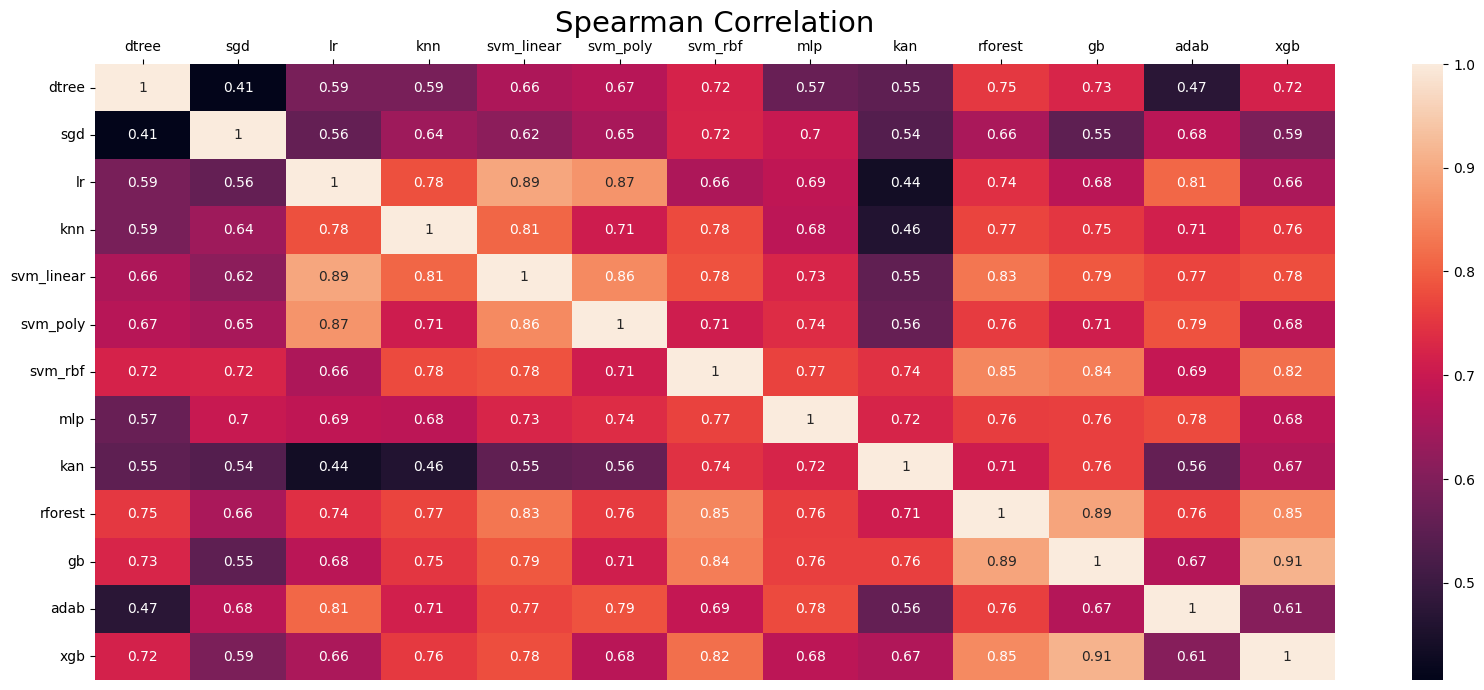

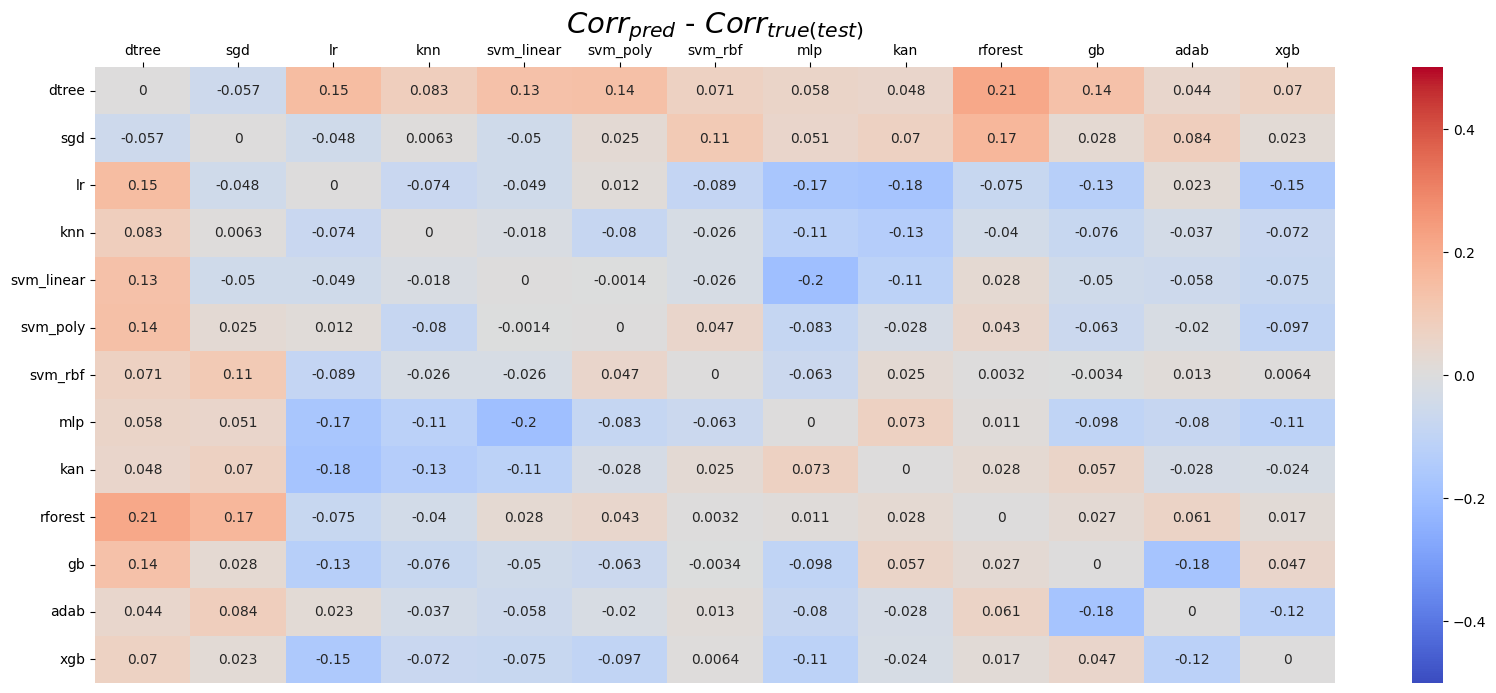

In [ ]:
regchainGroups_corrls = y_pred.corr('pearson')
pred_corrls2 = ya_test.corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchainGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = regchainGroups_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

In [396]:
print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['regchain(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['regchain(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['regchain(group)',:] = nmse_models(ya_test, y_pred)

mse_df

MSE: 0.0864
RMSE: 0.2763
MAE: 0.2124
NMSE: 0.9632


dtree       sgd        lr       knn  svm_linear  \
regchain             0.070750  0.144675  0.008020  0.088693    0.063051   
multi-output         0.070750  0.149822  0.008231  0.085860    0.057809   
individual           0.067037  0.153973  0.008214  0.086627    0.057277   
regchain(group)      0.070750  0.149822  0.008231  0.085860    0.058241   
multi-output(group)  0.070750  0.149822  0.008231  0.085860    0.058241   

                     svm_poly   svm_rbf       mlp       kan   rforest  \
regchain             0.085074  0.076151  0.119054  0.155764  0.049132   
multi-output         0.081284  0.081516  0.139950  0.160672  0.056684   
individual           0.087024  0.081461  0.132565  0.168477  0.055164   
regchain(group)      0.081284  0.077433  0.133253  0.160672  0.054623   
multi-output(group)  0.081284  0.077433  0.133253  0.160672  0.054623   

                           gb      adab       xgb  
regchain             0.121251  0.003830  0.091771  
multi-output         0.143984  0.003806  0.106339  
individual           0.138575  0.004350  0.093578  
regchain(group)      0.141778  0.003806  0.097445  
multi-output(group)  0.141778  0.003806  0.097445

### Multi-Output Regressor

In [344]:
mor4groups = []

for g in groups['true_assessor_train']:
    model = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train[g])
    mor4groups.append(model)

In [398]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mor4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

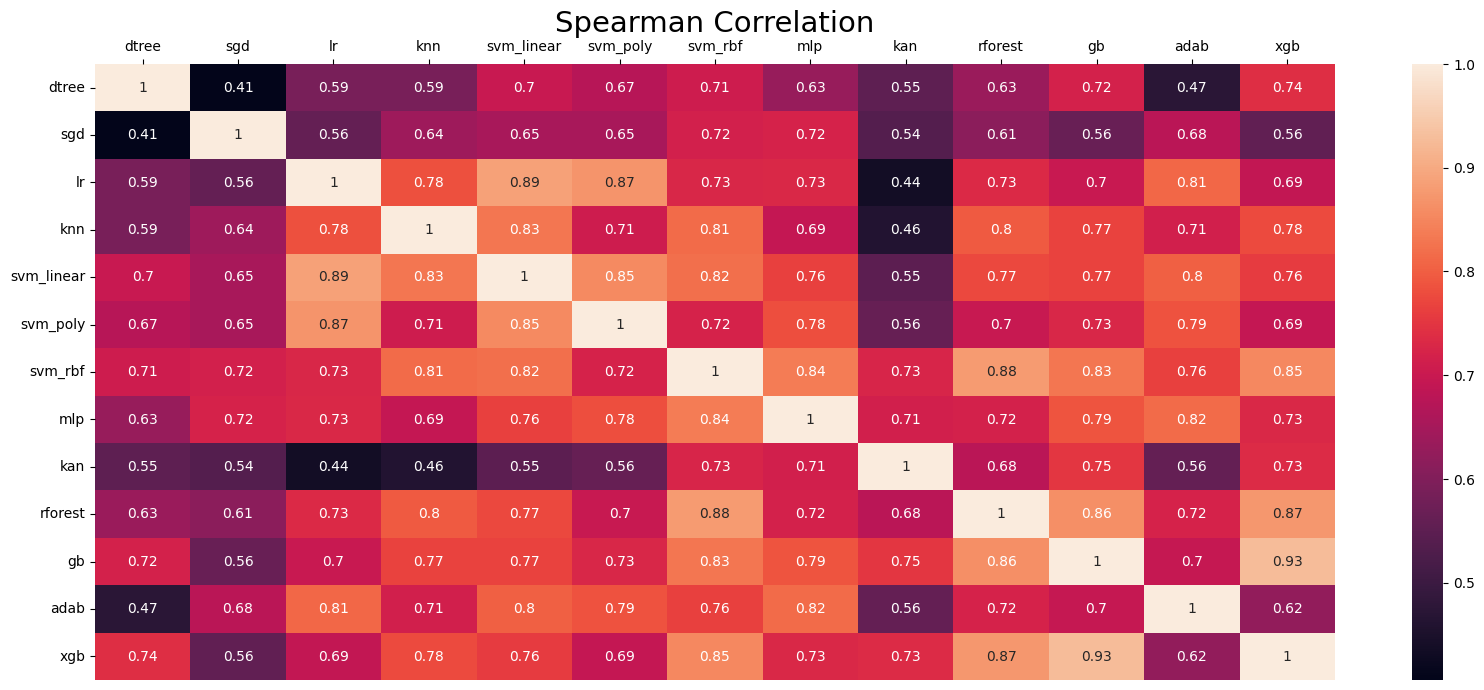

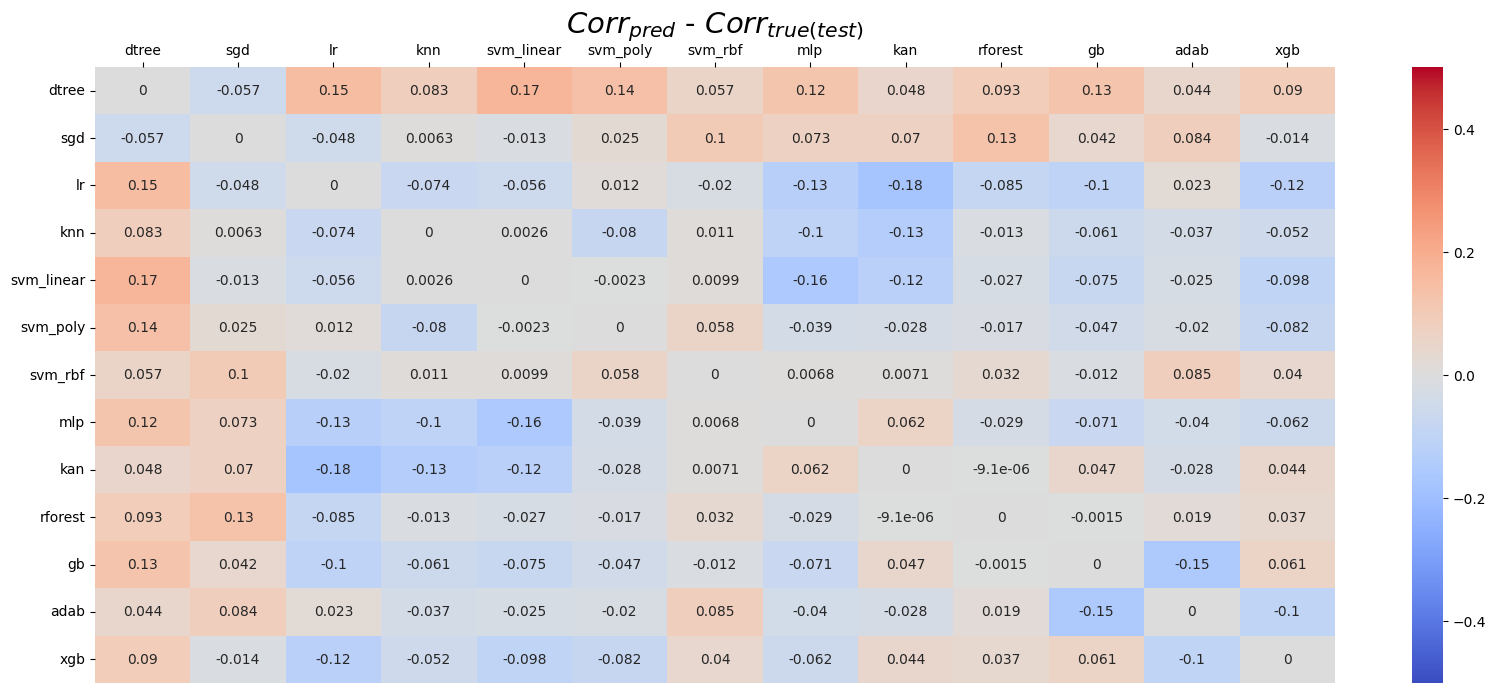

In [ ]:
morGroups_corrls = y_pred.corr('pearson')
#pred_corrls2 = ya_test.corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(morGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = morGroups_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

In [ ]:
print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['multi-output(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['multi-output(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['multi-output(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['multi-output(group)',:] = nmse_models(ya_test, y_pred)

mse_df

MSE: 0.0882
RMSE: 0.2791
MAE: 0.2145
NMSE: 0.9821


dtree       sgd        lr       knn  svm_linear  \
regchain             0.070750  0.144675  0.008020  0.088693    0.063051   
multi-output         0.070750  0.149822  0.008231  0.085860    0.057809   
individual           0.067037  0.153973  0.008214  0.086627    0.057277   
regchain(group)      0.070750  0.149822  0.008231  0.085860    0.057809   
multi-output(group)  0.070750  0.149822  0.008231  0.085860    0.058241   

                     svm_poly   svm_rbf       mlp       kan   rforest  \
regchain             0.085074  0.076151  0.119054  0.155764  0.049132   
multi-output         0.081284  0.081516  0.139950  0.160672  0.056684   
individual           0.087024  0.081461  0.132565  0.168477  0.055164   
regchain(group)      0.081284  0.081516  0.139950  0.160672  0.056684   
multi-output(group)  0.081284  0.077433  0.133253  0.160672  0.054623   

                           gb      adab       xgb  
regchain             0.121251  0.003830  0.091771  
multi-output         0.143984  0.003806  0.106339  
individual           0.138575  0.004350  0.093578  
regchain(group)      0.143984  0.003806  0.106339  
multi-output(group)  0.141778  0.003806  0.097445

## Análises

In [402]:
def metricsFormat(df: pd.DataFrame, metric_name:str):
    df = df.reset_index().melt(id_vars='index', var_name='model', value_name=metric_name)
    df = df.rename(columns={'index': 'assessor_type'})

    return df

In [403]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(rmse_df, 'RMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE      RMSE       MAE      NMSE
0              regchain  dtree  0.070750  0.265989  0.218292  0.914532
1          multi-output  dtree  0.070750  0.265989  0.218292  0.914532
2            individual  dtree  0.067037  0.258916  0.210124  0.866541
3       regchain(group)  dtree  0.070750  0.265989  0.218292  0.914532
4   multi-output(group)  dtree  0.070750  0.265989  0.218292  0.914532
..                  ...    ...       ...       ...       ...       ...
60             regchain    xgb  0.091771  0.302937  0.230105  0.973377
61         multi-output    xgb  0.106339  0.326096  0.250086  1.127896
62           individual    xgb  0.093578  0.305906  0.233025  0.992551
63      regchain(group)    xgb  0.106339  0.326096  0.250086  1.127896
64  multi-output(group)    xgb  0.097445  0.312162  0.240223  1.033567

[65 rows x 6 columns]

In [420]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[-1], sns.color_palette()[1]]

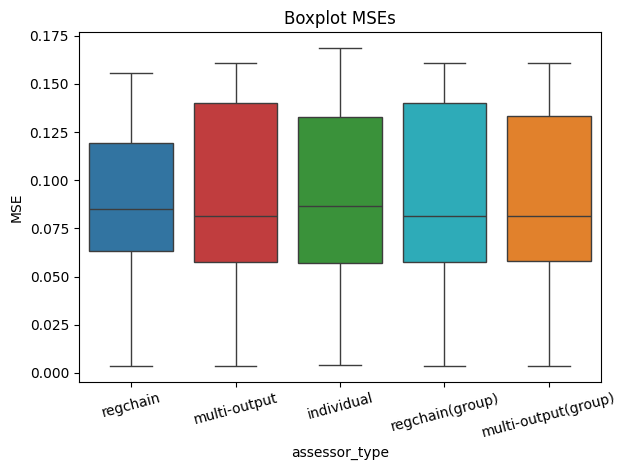

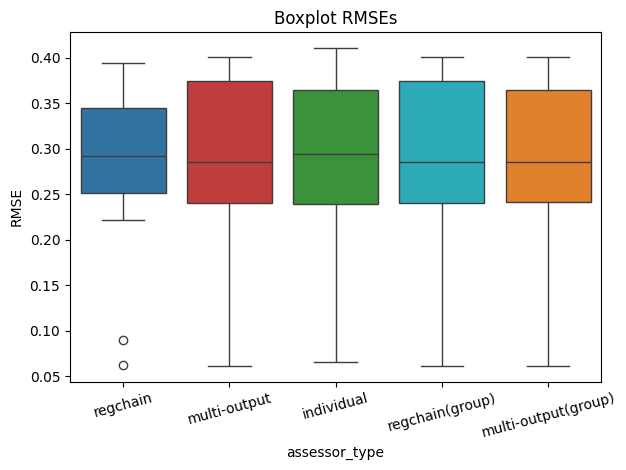

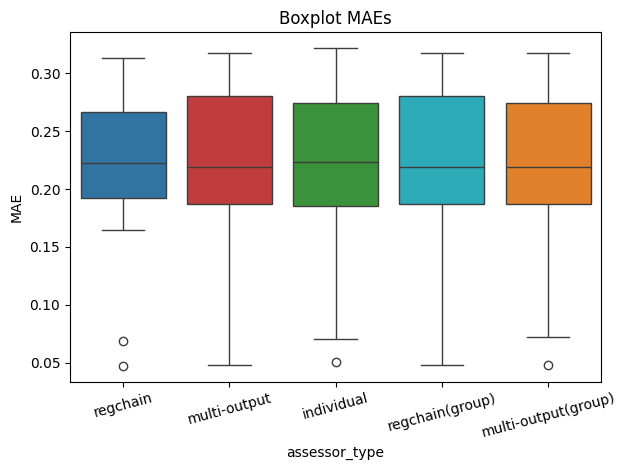

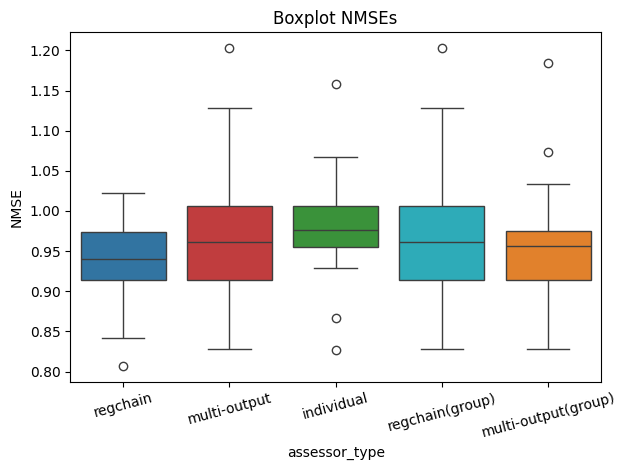

In [428]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.title(f'Boxplot {mt}s')
    sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

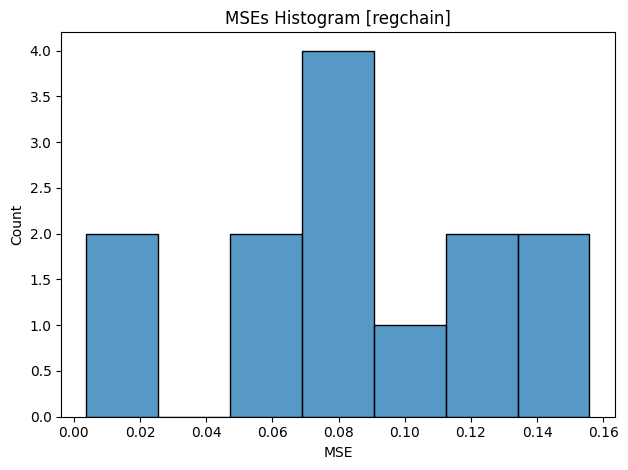

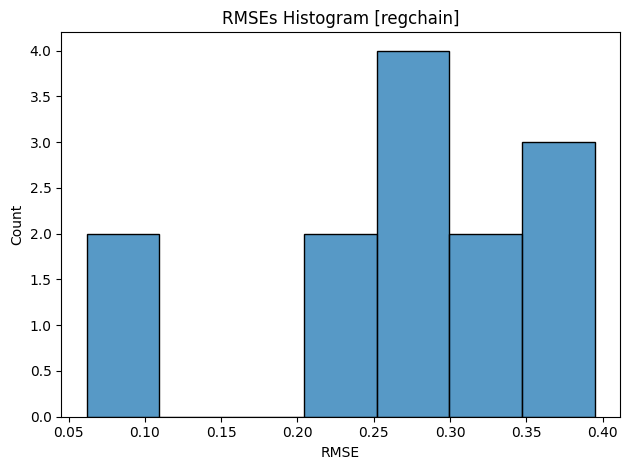

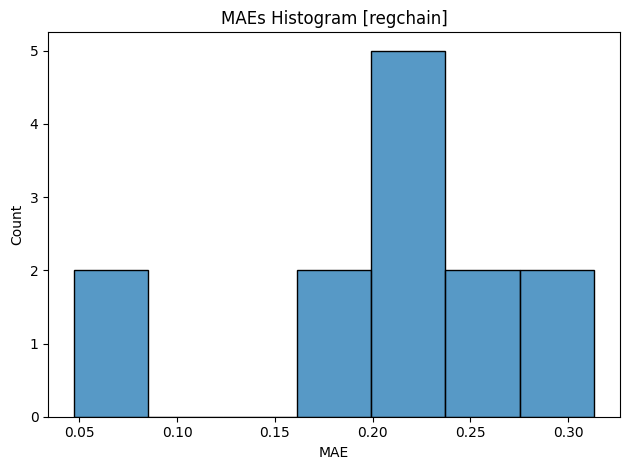

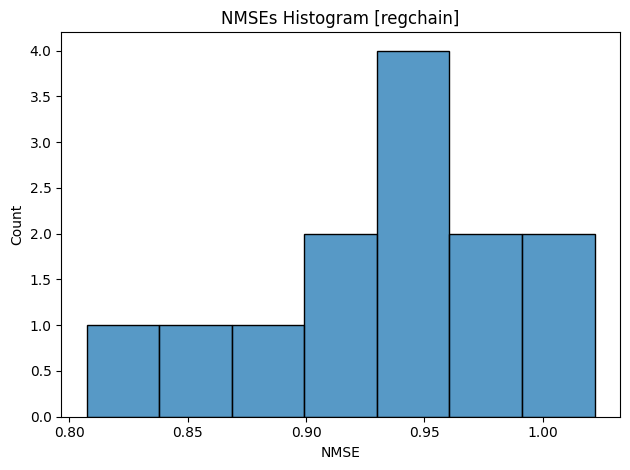

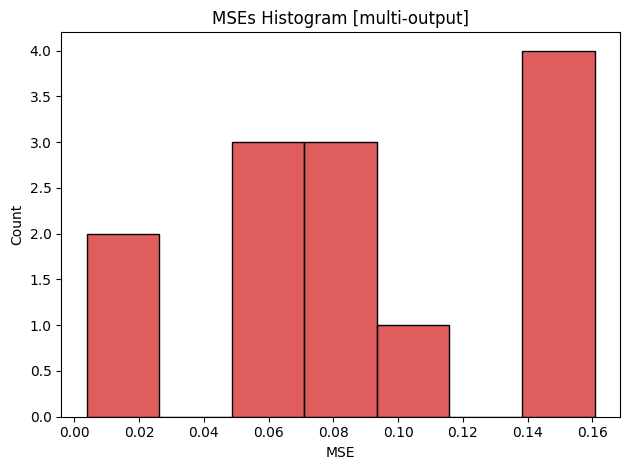

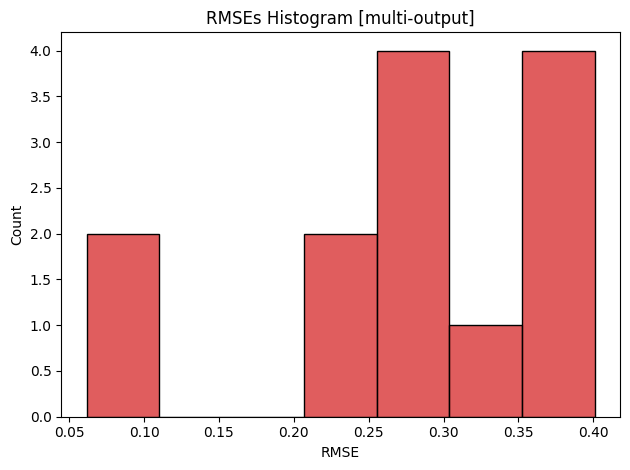

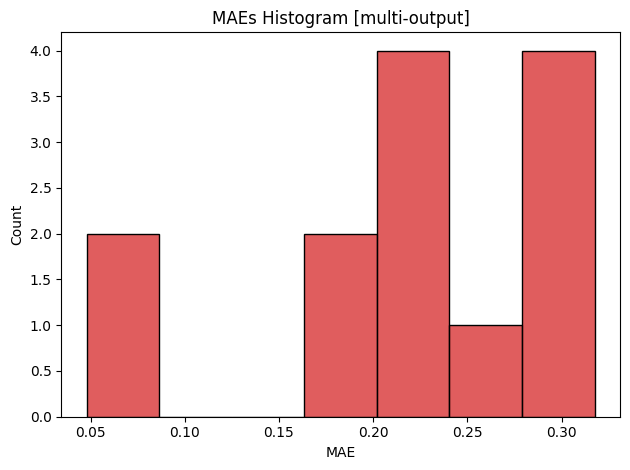

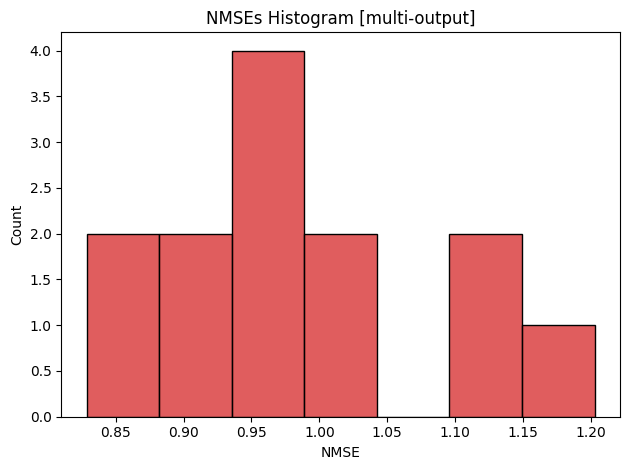

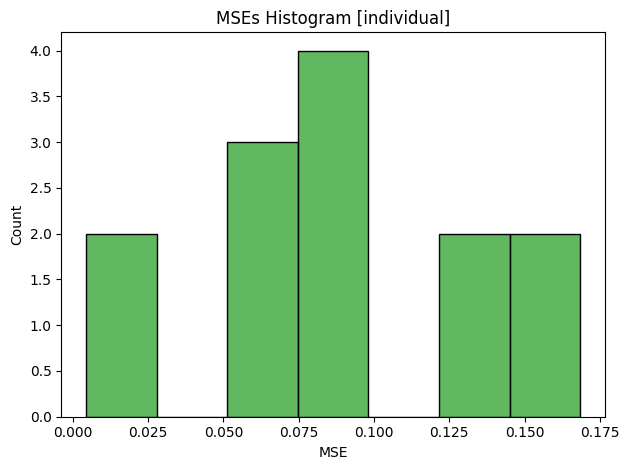

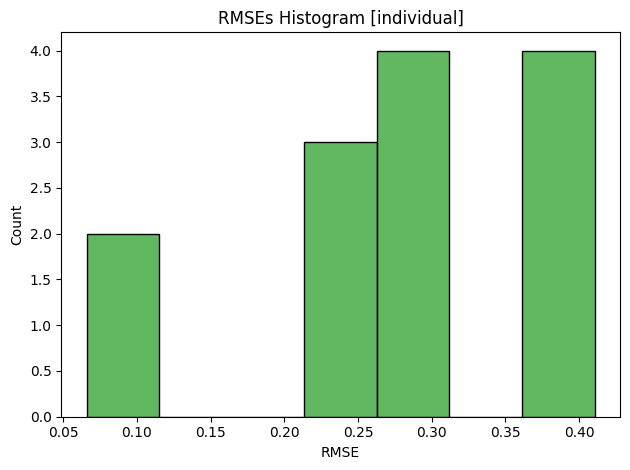

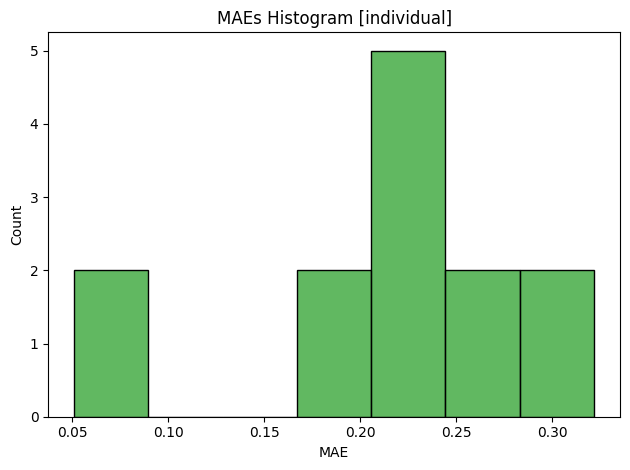

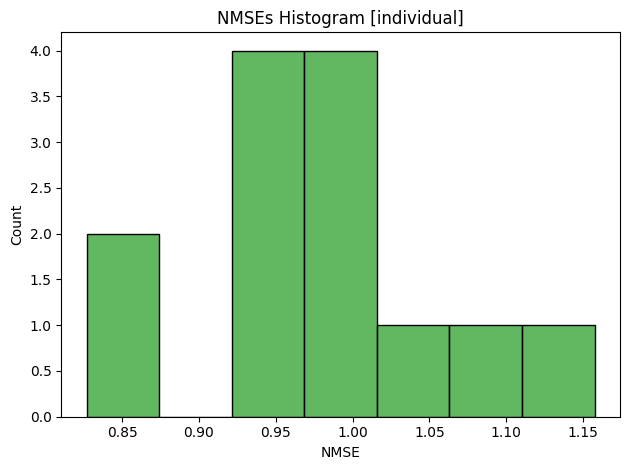

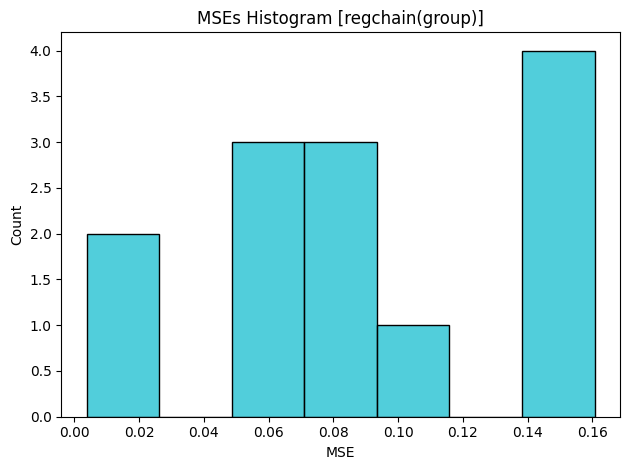

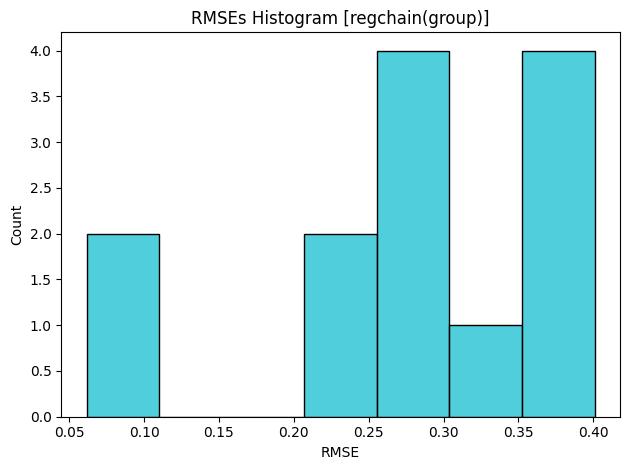

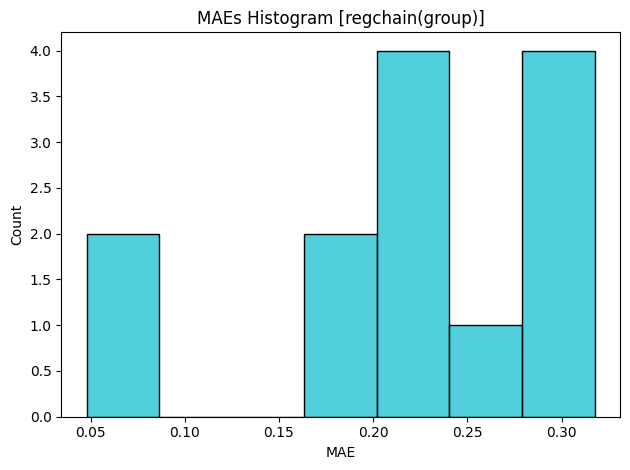

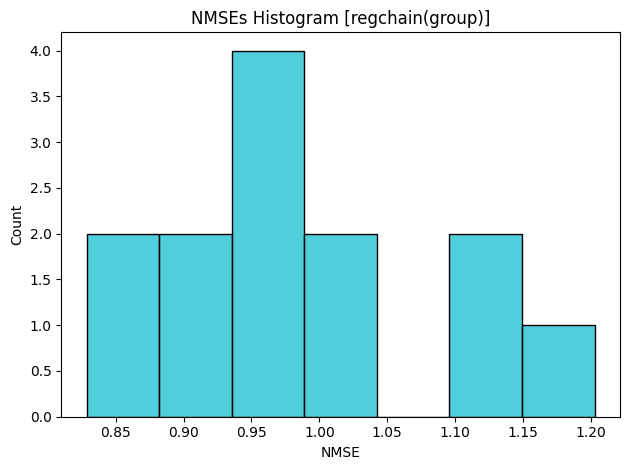

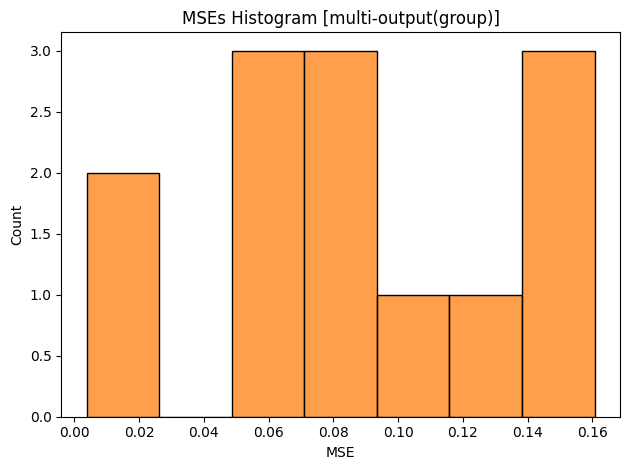

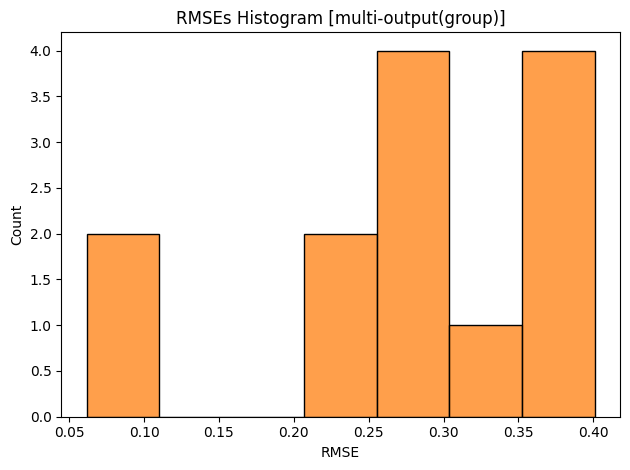

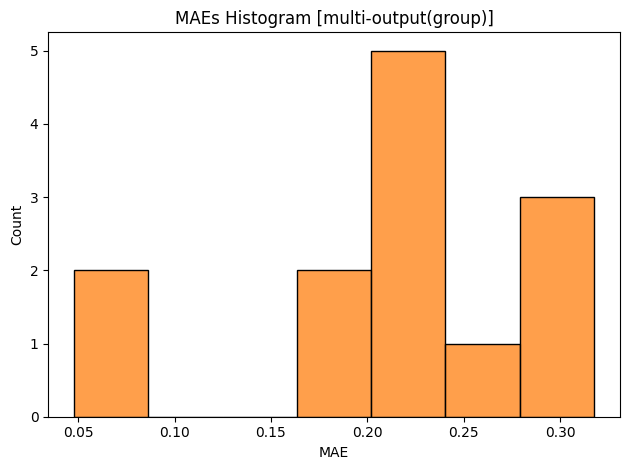

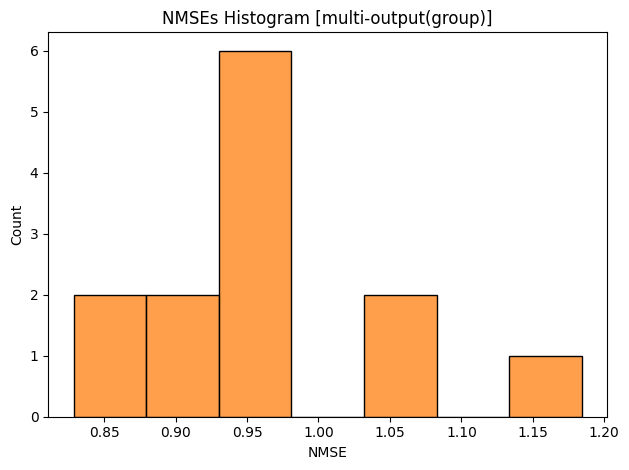

In [435]:
teste = {'regchain': class_palette[0], 
         'multi-output': class_palette[1], 
         'individual': class_palette[2],
         'regchain(group)': class_palette[3],
         'multi-output(group)': class_palette[4]}

for a in teste.keys():
    for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
        plt.title(f'{mt}s Histogram [{a}]')
        sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=teste[a])
        plt.tight_layout()
        plt.show()

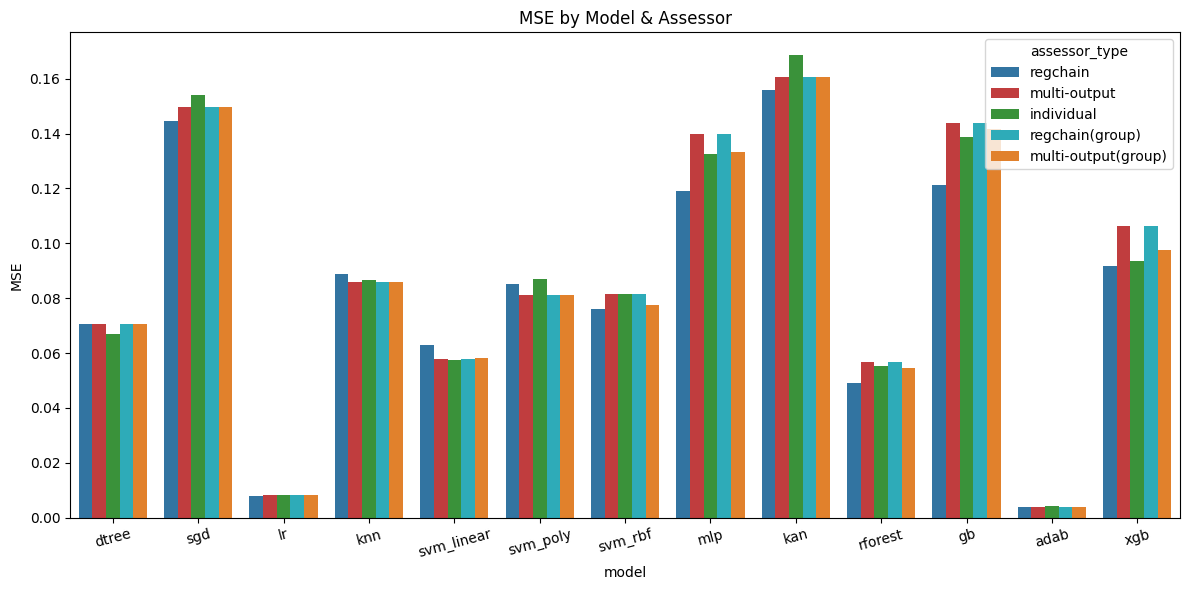

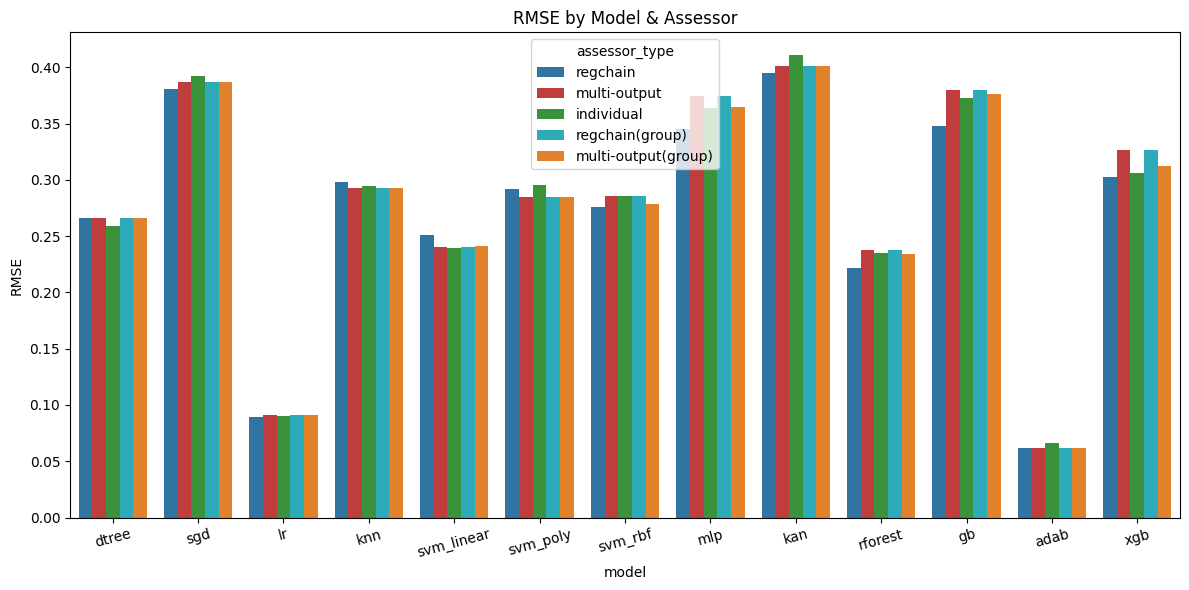

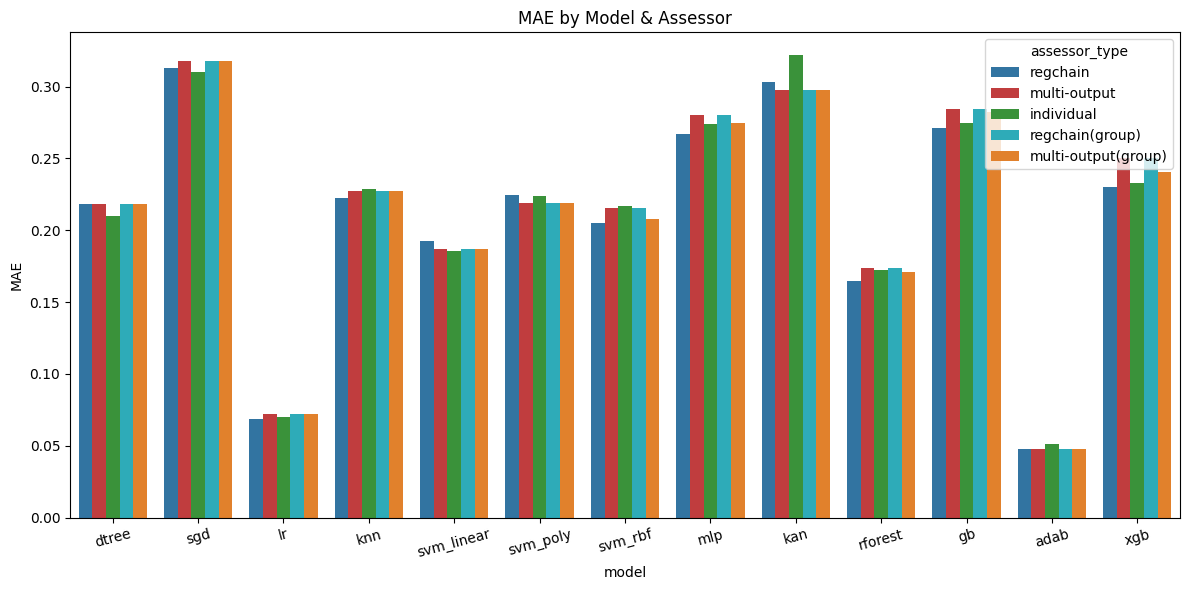

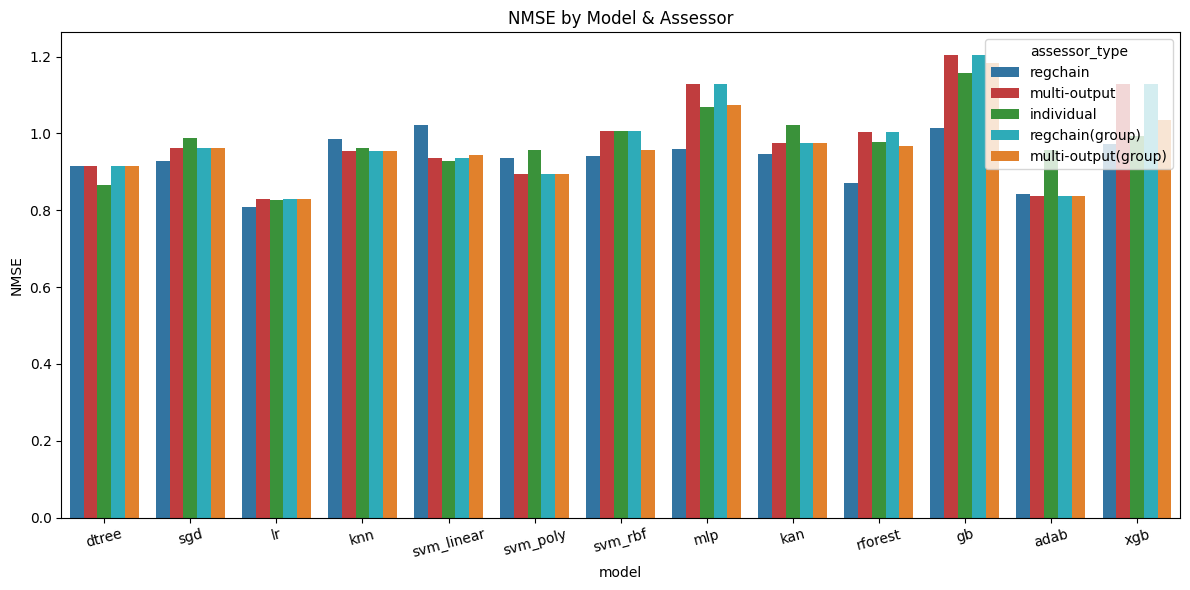

In [432]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()